# INM430 - Tiny DS Project
__Student Name__: Heiko Maerz <br>
__Project Title__: Analysis and Modelling of TfL Bikes Hires in London <br> <br>


In [1]:
# Note: some of the programming steps are performed not as straight forward and elegant as could be 
# (not that I claim to ever have written elegant code, I have not)
# but in a way that allows the analysis of intermediary steps, and I have done so for two reasons:
# 1) to enable me to observe and verify what happens in each step;
# 2) to enhance the learning effect for myself.
# Apologies for that.

# import main Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# optimise output
# source: https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Load Data
As my initial task I downloaded the .csv files for bike trips and weather and saved them according to the directory structure outlined below for loading and initial processing.

In [2]:
# TfL supplies bike trip information in weekly files, which results in 53 .csv files with a total of 10,102,680 individual trips;
# Weather Observations Website enables the download of monthly .csv files.
# loading the files and aggregating them in the first steps takes a fair amount of time,
# In order to speed subsequent executions of this Jupyter Notebook the aggregated data is saved as an intermediary file which can 
# be loaded to avoid processing the raw data source files, this is handled with a switch.

# import Python libraries used for data load
import datetime
import pathlib
import os

# helper functions to log and time-stamp processing steps
def print_timestamp(desc = 'n/a', display=False):
    """print a status message and time stamp (hour:minute:second)
    can be switched off via display parameter"""
    if display:
        print(f"{desc} at {datetime.datetime.now().strftime('%H:%M:%S')}")

# file structure:
# main project directory
# - subdirectory data
#   - subdirectory TfL        : bike trip .csv files downloaded from the TfL data store
#   - subdirectory MetOffice  : weather .csv files downloaded from met office
#   - subdirectory CityUoL    : weather .csv file provided by Aidan Slingsby          
#   - subdirectory ProjectData: processed .csv files for bike trips and weather
project_path = os.getcwd() 
print_timestamp(f"project file path: '{project_path}'", False)  
              
# this is the time frame of trips to consider
date_time_range = pd.date_range(pd.to_datetime('01/04/2017 00:00', dayfirst = True),
                                pd.to_datetime('31/03/2018 23:30', dayfirst = True),
                                freq='30min')              

## 1.1 Bike Trip Data

"Santander Cycle Hire" data is available at the TfL data store in the form of weekly .csv files. Each file contains unique bike rentals. This report aims to analyse and model bike trip volumes throughout the period April 2017 to March 2018. I will extract the start date and time for each bike rental and aggregate all resulting trips into 30 minute intervals.

In [3]:
# switch to load and process 53 raw TfL data .csv files or load intermediary file
import_raw_trip_data = False

# display or suppress status messages
verbose = True

# initialise aggregate trip data
bike_trips = pd.DataFrame()


def load_processed_trip_data():
    """trip data was processed in a previous run, 
    load it for further processing to save time.
    File description: 
    - time stamp, format dd/mm/yyyy h24:min, start time for each 30 minute time period
    - total volume of bike trips"""
    # file path and name according to directory structure 
    file_name = f"Bike_Trips_Resampled.csv"
    file_name = os.path.join(project_path, 'data/ProjectData', file_name)
    # no error handling, this is a known file and should work
    trips = pd.read_csv(file_name)
    # convert date and time imported as object into date time data type
    trips['time_stamp'] = pd.to_datetime(trips['time_stamp'], dayfirst=True)
    # set as index
    trips.set_index('time_stamp', inplace=True)
    return trips


def load_raw_bike_trip_files():
    """load all TfL bike rental files and process"""
    print_timestamp(f"Start trip data import from TfL .csv files", True)

    # set file paths
    upload_path = os.path.join(project_path, 'data/TfL')
    # all trip files
    trip_files = os.listdir(upload_path)
    trip_files.sort() # makes it easier to keep track of progress

    # initialise bike trip table
    trips = pd.DataFrame()

    # process the files
    for file_name in trip_files:
        if '.DS_Store' == file_name: #MacOS hidden file, ignore
            continue
        # initialise trips for each file
        file_trips = pd.DataFrame()
        # load weekly .csv files and aggregate bike trips into 30 minute time intervals
        file_trips = read_trip_file(upload_path, file_name)
        # collect the data
        if not file_trips.empty:
            trips = trips.append(file_trips)
            
    # process and download all 
    if not trips.empty:
        # sort
        trips.sort_index(inplace=True)
        # the TfL files are per week and may start before or end after the time considered
        df_idx = trips.index.isin(date_time_range)
        trips = trips[df_idx]
        # save processed data as intermediary file
        file_name = f"Bike_Trips_Resampled.csv"
        outfile = os.path.join(project_path, 'data/ProjectData', file_name)
        print_timestamp(f"saving file '{file_name}'", True)
        trips.to_csv(outfile)
    # and return all processed and aggregated trips 
    print_timestamp(f"trip data import finished", True)
    return trips


def read_trip_file(file_path, file_name):
    """load individual TfL bike rental .csv file, 
    aggregate rentals into 30 minute time periods, and 
    return the aggregates for each file"""
    file_data = pd.DataFrame()
    try:
        print_timestamp(f"open file '{file_name}'", verbose)
        file_path = os.path.join(file_path, file_name) # I will use the filename for output
        raw_data = pd.read_csv(file_path)
        # each line corresponds to one trip, get the start date as a proper time/date data type
        # this analysis only considers the rental volume which will be associated with the start date and time
        raw_data['time_stamp'] = pd.to_datetime(raw_data['Start Date'], dayfirst=True)
        # each trip has a date and time and corresponds to 1 trip, hence the counter
        file_data = raw_data.loc[:,['time_stamp']]
        file_data['bike_trips'] = 1
        # probably not necessary
        file_data.sort_values('time_stamp', inplace=True)
        # aggregate all trips into 30 minute intervals
        file_data.set_index('time_stamp', inplace=True)
        file_data = file_data.resample('30min').sum()
    except:
        print(f"could not read file '{file_name}'")
    return file_data


if import_raw_trip_data:
    # import raw TfL trip data if required
    bike_trips = load_raw_bike_trip_files()
else:
    # load previously processed and aggregated bike trip data
    bike_trips = load_processed_trip_data()
    
# some information about the bike trips
print(f"First bike trip in 30 minute period starting {bike_trips.index[0]}, total trips for this time period {bike_trips.bike_trips.iloc[0]}")
print(f"Last bike trip in 30 minute period staring {bike_trips.index[-1]}, total trips for this time perion {bike_trips.bike_trips.iloc[-1]}\n")
print(f"Total number of bike trips: {bike_trips.bike_trips.sum()} in {len(bike_trips.index)} observations")
#bike_trips.head()

First bike trip in 30 minute period starting 2017-04-01 00:00:00, total trips for this time period 240
Last bike trip in 30 minute period staring 2018-03-31 23:30:00, total trips for this time perion 102

Total number of bike trips: 10102680 in 17520 observations


## 1.2 Weather Data

For this project I have used two different weather data files and combined those to complement each other as described below. Each of the files has more than one observation for each 30 minute time period, and the weather data is aggregated as follows:

- Temperature: mean of all observations;
- Rainfall: max of all observations;
- Wind: mean of all observations.

### 1.2.1 City, University of London
Data used is one .csv file with weather data for 2017.

### 1.2.2 Met Office Weather Observation Website
Data used is one .csv file for each month, a total of 52 fields of which 'Report Date / Time', 'Air Temperature', 'Rainfall Rate', and 'Wind Speed' are of interest.

### 1.2.3 Combined Weather Data
The use of two sources for weather data allows to average outliers and both sources can complement each other in case of missing data. This means that if data is present in both datasets, I will use the mean, if it is missing in one dataset, I will use the value of the other. I will try to merge them using this strategy:
- __Temperature__: mean; 
- __Rainfall__: the units of measure do not correspond to each other. For that reason I will treat rain as a categorical variable: if either dataset reports rain the attribute will have 1 for 'rain', otherwise 0 for 'no rain';
- __Wind speed__: mean.

In [50]:
# switch to load and process 12 raw data .csv files or load intermediary file
import_raw_weather_data = False

# display or suppress status messages
verbose = True

# initialise weather data
weather = pd.DataFrame()


def load_processed_weather_files():
    """load pre-processed weather files for City and Met Office"""
    # City weather
    file_name = f"Weather_City_Resampled.csv"
    file_name = os.path.join(project_path, 'data/ProjectData', file_name)
    city_weather = pd.read_csv(file_name)
    city_weather.time_stamp = pd.to_datetime(city_weather.time_stamp, dayfirst=True)
    city_weather.sort_values('time_stamp', inplace=True)
    print(f"City weather missing values:\n{city_weather.shape[0] - city_weather.count()}\n")
    # Met Office weather
    file_name = f"Weather_MetOffice_Resampled.csv"
    file_name = os.path.join(project_path, 'data/ProjectData', file_name)
    met_weather = pd.read_csv(file_name)
    met_weather.time_stamp = pd.to_datetime(met_weather.time_stamp, dayfirst=True)
    met_weather.sort_values('time_stamp', inplace=True)
    #met_weather.set_index('time_stamp', inplace=True) 
    print(f"Met Office weather missing values:\n{met_weather.shape[0] - met_weather.count()}\n")
    return city_weather, met_weather


def load_raw_weather_files():
    """load raw weather files from MetOffice and City, University of London, process and aggregate, and save for later processing"""
    print_timestamp(f"Start weather data import", True)

    # initialise aggregate City UoL weather
    city_weather = pd.DataFrame()
    # set file paths
    upload_path = os.path.join(project_path, 'data/CityUoL')
    # all journey files
    weather_files = os.listdir(upload_path)
    weather_files.sort()
    # process the files
    for file_name in weather_files:
        if '.DS_Store' == file_name:  # MacOS hidden file, ignore
            continue
        # load raw City weather, aggregate temperature, rain, and wind data into 30 minute time intervals    
        file_weather = load_raw_city_weather(upload_path, file_name)
        if not file_weather.empty:
            city_weather = city_weather.append(file_weather)
    # and save intermediary file
    if not city_weather.empty:
        file_name = f"Weather_City_Resampled.csv"
        file_name = os.path.join(project_path, 'data/ProjectData', file_name)
        print_timestamp(f"saving file '{file_name}'", True)
        city_weather.to_csv(file_name, index=False)
        print(f"City weather missing values:\n{city_weather.shape[0] - city_weather.count()}\n")

    # initialise aggregate Met Office weather
    met_weather = pd.DataFrame()
    # set file paths
    upload_path = os.path.join(project_path, 'data/MetOffice')
    # all journey files
    weather_files = os.listdir(upload_path)
    weather_files.sort() # easier to keep track
    # process the files
    for file_name in weather_files:
        if '.DS_Store' == file_name:  # MacOS hidden file, ignore
            continue
        # load raw Met Office weather, aggregate temperature, rain, and wind data into 30 minute time intervals   
        file_weather = load_raw_met_office_file(upload_path, file_name)
        if not file_weather.empty:
            met_weather = met_weather.append(file_weather)
    # and save intermediary file
    if not met_weather.empty:
        file_name = f"Weather_MetOffice_Resampled.csv"
        file_name = os.path.join(project_path, 'data/ProjectData', file_name)
        print_timestamp(f"saving file '{file_name}'", True)
        met_weather.to_csv(file_name, index=False) 
        print(f"Met Office weather missing values:\n{met_weather.shape[0] - met_weather.count()}\n")
    
    # return both weather files for further processing
    return city_weather, met_weather
            
            
def load_raw_city_weather(file_path, file_name):
    """load raw city weather file, 
    get temperature, rain fall, and wind,
    aggregate for 30 minute time periods:
    - average for temperature,
    - maximum for rain,
    - maximum for wind"""
    # initialise local data frames for temperature, rain, wind, and merged weather
    temperature = pd.DataFrame()
    rain = pd.DataFrame()
    wind = pd.DataFrame()
    weather = pd.DataFrame()
    # read the file, catch exceptions
    try:
        print_timestamp(f"open file '{file_name}", verbose)
        # file path and name
        file_path = os.path.join(file_path, file_name)  # I will use the filename to print the lines
        file_data = pd.read_csv(file_path)
        # just need the date and time, temperature(s), rain, and wind
        lcl_weather = file_data.loc[:, ['t', 'app_temp', 'rain_last_hour', 'avg_wind', 'gust_wind', 'daylight']]
        # convert the weather observation date and time into a time-stamp and index for later re-sampling
        lcl_weather['time_stamp'] = pd.to_datetime(lcl_weather['t'], dayfirst=True)
        lcl_start_date = lcl_weather.time_stamp.min().replace(hour=0, minute=0, second=0)
        lcl_end_date = lcl_weather.time_stamp.max().replace(hour=23, minute=30, second=0)
        lcl_weather.sort_values('time_stamp', inplace=True)
        lcl_weather.set_index('time_stamp', inplace=True)
        # temperature: re-sample to half hour, mean
        temperature['city_temperature'] = lcl_weather.loc[:, 'app_temp'].dropna()
        temperature = temperature.resample('30min').mean()
        # rain: re-sample to half hour, max
        rain['city_rainfall'] = lcl_weather.loc[:, 'rain_last_hour'].dropna()
        rain = rain.resample('30min').max()
        # wind: re-sample to half hour, max
        wind['city_wind_speed'] = lcl_weather.loc[:, ['avg_wind', 'gust_wind']].mean(axis=1).dropna()
        wind = wind.resample('30min').mean()
        # merge half hour temperature, rain, and wind observations read in from file
        weather['time_stamp'] = pd.date_range(lcl_start_date, lcl_end_date, freq='30min')
        weather = pd.merge(weather, temperature, left_on='time_stamp', right_index=True, how='left')
        weather = pd.merge(weather, rain, left_on='time_stamp', right_index=True, how='left')
        weather = pd.merge(weather, wind, left_on='time_stamp', right_index=True, how='left')
    except:
        print(f"could not process file '{file_name}'")
    return weather  


def load_raw_met_office_file(file_path, file_name):
    """load raw met office weather file, 
    get temperature, rain fall, and wind,
    aggregate for 30 minute time periods:
    - average for temperature,
    - maximum for rain,
    - maximum for wind"""
    # initialise local data frames for temperature, rain, wind, and merged weather
    temperature = pd.DataFrame()
    rain = pd.DataFrame()
    wind = pd.DataFrame()
    weather = pd.DataFrame()
    # read the file, catch exceptions
    try:
        print_timestamp(f"open file '{file_name}")
        # file path and name
        file_path = os.path.join(file_path, file_name)  # I will use the filename to print the lines
        file_data = pd.read_csv(file_path)
        # just need the date and time, temperature, rain, and wind
        lcl_weather = file_data.loc[:, ['Report Date / Time', 'Air Temperature', 'Rainfall Rate', 'Wind Speed']]
        # convert the weather observation date and time into a time-stamp and index for later re-sampling
        lcl_weather['time_stamp'] = pd.to_datetime(lcl_weather['Report Date / Time'], dayfirst=True)
        lcl_start_date = lcl_weather.time_stamp.min().replace(hour=0, minute=0, second=0)
        lcl_end_date = lcl_weather.time_stamp.max().replace(hour=23, minute=30, second=0)
        lcl_weather.sort_values('time_stamp', inplace=True)
        lcl_weather.set_index('time_stamp', inplace=True)
        # temperature: re-sample to half hour, mean
        temperature['met_temperature'] = lcl_weather.loc[:, 'Air Temperature'].dropna()
        temperature = temperature.resample('30min').mean()
        # rain: re-sample to half hour, max
        rain['met_rainfall'] = lcl_weather.loc[:, 'Rainfall Rate'].dropna()
        rain = rain.resample('30min').max()
        # wind: re-sample to half hour, max
        wind['met_wind_speed'] = lcl_weather.loc[:, 'Wind Speed'].dropna()
        wind = wind.resample('30min').max()
        # merge half hour temperature, rain, and wind observations read in from file
        weather['time_stamp'] = pd.date_range(lcl_start_date, lcl_end_date, freq='30min')
        weather = pd.merge(weather, temperature, left_on='time_stamp', right_index=True, how='left')
        weather = pd.merge(weather, rain, left_on='time_stamp', right_index=True, how='left')
        weather = pd.merge(weather, wind, left_on='time_stamp', right_index=True, how='left')
    except:
        print(f"could not read file '{file_name}'")
    #print(f"weather data types:\n{weather.dtypes}\n")
    return weather


def process_weather(import_raw_weather_data):
    """aggregate City and Met Office weather files"""
    # load raw or pre-processed data?
    if import_raw_weather_data:
        city_weather, met_weather = load_raw_weather_files()
    else:
        city_weather, met_weather = load_processed_weather_files()
    
    # initialise weather
    lcl_weather = pd.DataFrame()
    # one row for each 30 minute time interval 
    lcl_weather['time_stamp'] = date_time_range 
    # merge City, UoL weather on time stamp
    if not city_weather.empty:
        lcl_weather = pd.merge(lcl_weather, city_weather, left_on='time_stamp', right_on='time_stamp', how='left')
    # merge Met Office weather on time stamp
    if not met_weather.empty:
        lcl_weather = pd.merge(lcl_weather, met_weather, left_on='time_stamp', right_on='time_stamp', how='left')

    # process and download all
    if not lcl_weather.empty:
        # merging is done in more steps than necessary with more columns than necessary,
        # however this gives me the opportunity to verify and learn
        # use both data sets to get the London Weather
        # the temperature for both data sources is consistent to roughly 1 degree, get the mean and round to 1/10
        lcl_weather['temperature'] = lcl_weather.loc[:, ['met_temperature', 'city_temperature']].mean(axis=1)
        lcl_weather['temperature'] = lcl_weather.temperature.round(1)
        # rain uses different units, create categorical attribute {rain, no rain}
        # fill gaps first
        lcl_weather.met_rainfall.fillna(lcl_weather.city_rainfall, inplace=True)
        lcl_weather.city_rainfall.fillna(lcl_weather.met_rainfall, inplace=True)
        # set rainfall to 1 if any of the sources have rainfall, else to 0
        lcl_weather['rainfall'] = np.where((lcl_weather[['city_rainfall', 'met_rainfall']].max(axis=1)) > 0, 1, 0)
        # merge wind, later analysis shows large gaps, and wind will be ignored
        lcl_weather['wind_speed'] = lcl_weather.loc[:, ['met_wind_speed', 'city_wind_speed']].mean(axis=1)
        lcl_weather['wind_speed'] = lcl_weather.wind_speed.round(1)
        # sort
        lcl_weather.set_index('time_stamp', inplace=True)
        lcl_weather.sort_index(inplace=True)
        
        # swap columns, drop individual entries for City and Met Office data
        swap_columns = ['temperature', 'met_temperature', 'city_temperature',
                        'rainfall', 'met_rainfall', 'city_rainfall',
                        'wind_speed', 'met_wind_speed', 'city_wind_speed']
        lcl_weather = lcl_weather.reindex(columns=swap_columns)
        # drop columns
        lcl_weather = lcl_weather.loc[:,['temperature', 'rainfall', 'wind_speed']]   
    
    return lcl_weather

# get weather data
weather = process_weather(import_raw_weather_data)

print(f"Merged weather data missing values:\n{weather.shape[0] - weather.count()}\n")

weather.describe()

City weather missing values:
time_stamp             0
city_temperature    5388
city_rainfall       5388
city_wind_speed     5388
dtype: int64

Met Office weather missing values:
time_stamp           0
met_temperature     92
met_rainfall       288
met_wind_speed     631
dtype: int64

Merged weather data missing values:
temperature     34
rainfall         0
wind_speed     512
dtype: int64



,temperature,rainfall,wind_speed
count,17486.000000,17520.000000,17008.000000
mean,12.496826,0.054680,3.325876
std,6.628602,0.227362,2.284097
min,-3.800000,0.000000,0.000000
25%,7.600000,0.000000,1.800000
50%,12.400000,0.000000,2.600000
75%,16.900000,0.000000,4.300000
max,38.300000,1.000000,28.700000


Merging both weather datasets resulted in complete data for rainfall, albeit as categorical variable.<br>
Temperature only has 34 missing entries out of a total of 17486 observations, while wind speed has 512. The literature suggests a strong influence of temperature but a low influence of wind on bike use in an urban environment. For that reason I will drop the 34 observations with missing temperature and ignore wind speed for further analysis and modelling. <br>

In [5]:
# wind data has large gaps and will be ignored
# drop all rows that do not have data for temperature AND rainfall
no_temperature_idx = weather['temperature'].isnull()
no_rainfall_idx    = weather['rainfall'].isnull()
no_weather_idx     = no_temperature_idx | no_rainfall_idx
#print(f"index for all columns that have no weather:\n{no_weather_idx.head(5)}\n")
weather = weather[~no_weather_idx]
# for graphs
weather['Temp'] = weather.temperature.round(0)
print(f"merged weather after dropping missing values for temperature and rain:\n{weather.shape[0] - weather.count()}\n") 

merged weather after dropping missing values for temperature and rain:
temperature      0
rainfall         0
wind_speed     488
Temp             0
dtype: int64



# 2 Data Wrangling
## 2.1 Date and time attributes:
I will derive the following additional date and time dependent features for further analysis:
- Month to analyse the effect of season, numerical attribute;
- Workday: Monday to Friday except UK bank holidays, categorical 1 (workday) or 0 (weekend or bank holiday);
- Half hour time intervals as decimals (i.e.14:30 is converted to 14.5);
- TfL peak travel hours as categorical variable, 0 off-peak and 1 peak travel hours (peak travel on workdays only).

In [7]:
# build date and time dependent attributes
def compute_date_time_attributes(weather):
    """returns a dataframe for time dependent attributes:
    - time_stamp for 30 minute time intervals matching bike trip and weather data
    - month as integer 1~12
    - workday as categorical: 0 not a workday, 1 workday
    - hour floating point number corresponding to 30 minute time intervals
    - peak_travel as categorical: 0 not peak, 1 peak """
    # England bank holidays for 2017 and 2018, source: https://www.gov.uk/bank-holidays
    bank_hols_list = ['02/01/2017', # New Year's Day substitute
                      '14/04/2017', # Good Friday
                      '17/04/2017', # Easter Monday
                      '01/05/2017', # Early May
                      '29/05/2017', # Spring
                      '28/08/2017', # Summer
                      '25/12/2017', # Christmas Day
                      '26/12/2017', # Boxing Day
                      '01/01/2018']  # New Year's
    bank_hols = pd.DatetimeIndex(bank_hols_list, dayfirst=True)

    # peak travel hours 
    wd_peak = [6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5,  # morning peak
               16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0] #, 19.5, 20.0, 20.5] # evening peak

    date_time_attributes = pd.DataFrame()
    date_time_attributes['time_stamp'] = weather.index # only process observation for which we have weather
    date_time_attributes['date'] = date_time_attributes.time_stamp.dt.date.astype('datetime64')
    date_time_attributes['month'] = date_time_attributes.time_stamp.dt.month
    date_time_attributes['weekday'] = date_time_attributes.time_stamp.dt.weekday
    date_time_attributes['wd_name'] = date_time_attributes.time_stamp.dt.weekday_name # allows your fearless student to double-check
    date_time_attributes['workday'] = np.where((date_time_attributes.weekday == 5) | (date_time_attributes.weekday == 6), 0, 1) #-1, 1)
    date_time_attributes['workday'] = np.where(date_time_attributes['date'].isin(bank_hols), 0, date_time_attributes.workday) #-1, date_time_attributes.workday)
    date_time_attributes['time'] = date_time_attributes.time_stamp.dt.time
    date_time_attributes['hour'] = date_time_attributes.time_stamp.dt.hour + date_time_attributes.time_stamp.dt.minute / 60
    date_time_attributes['peak_travel'] = np.where((date_time_attributes.workday==1) & (date_time_attributes.hour.isin(wd_peak)),1,0)
    
    date_time_attributes = date_time_attributes.loc[:,['time_stamp', 'month', 'workday', 'hour', 'peak_travel']]
    
    return date_time_attributes


# combine weather, time and date attributes, and bike trips
date_time_attributes = compute_date_time_attributes(weather)

## 2.2 Merge Weather, Time and Date Attributes, and Bike Trip Data
To be able to observe the effect of temperature and rain on bike trip volumes I will drop bike trip observations for the time periods for which I do not have weather data. I now have a dataset with 17486 observations for further analysis.

In [8]:
# merge weather, trips, and date and time attributes
all_trips = pd.DataFrame()
all_trips = pd.merge(bike_trips, weather[['temperature', 'Temp', 'rainfall']], left_index=True, right_index=True, how='right')
all_trips = pd.merge(all_trips, date_time_attributes[['time_stamp', 'month', 'workday', 'hour', 'peak_travel']], left_index=True, right_on='time_stamp', how='left')
all_trips.set_index('time_stamp', inplace=True)

all_trips.describe()

,bike_trips,temperature,Temp,rainfall,month,workday,hour,peak_travel
count,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000
mean,576.640684,12.496826,12.497770,0.054729,6.533055,0.690038,11.746226,0.201190
std,564.769074,6.628602,6.635213,0.227458,3.444817,0.462491,6.929231,0.400901
min,0.000000,-3.800000,-4.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,113.000000,7.600000,8.000000,0.000000,4.000000,0.000000,5.500000,0.000000
50%,429.000000,12.400000,12.000000,0.000000,7.000000,1.000000,11.500000,0.000000
75%,830.000000,16.900000,17.000000,0.000000,10.000000,1.000000,17.500000,0.000000
max,2898.000000,38.300000,38.000000,1.000000,12.000000,1.000000,23.500000,1.000000


# 3 Exploratory Data Analysis

In [9]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr

# colour palettes for consistent displays
pal_workday = ['moccasin', 'lightsteelblue']
pal_rain = ['gold', 'dodgerblue']

# a few handy dictionaries
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# helper functions
def temperature_palette(temperatures): #bt_plot.temperature.unique() 
    """return a color palette for the full range of temperatures"""
    tlen = len(temperatures.unique())
    return sns.diverging_palette(250, 10, n=tlen, center='light')

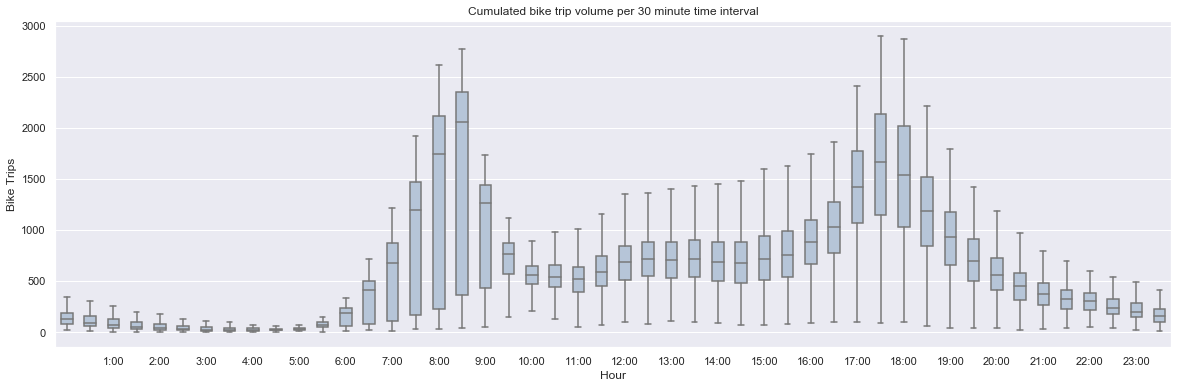

In [52]:
# plot the distribution 
sns.set(rc={'figure.figsize': (20,6)})

ax = sns.boxplot(x='hour', y='bike_trips', data=all_trips, showfliers=False, color='lightsteelblue', width=.5,)
ax.set_title(f"Cumulated bike trip volume per 30 minute time interval")
hndl, lgnd = ax.get_legend_handles_labels()
ax.set_xticklabels(['', '', '1:00', '', '2:00', '', '3:00', '', '4:00', '', '5:00', '', '6:00', '', '7:00', '', '8:00', '', '9:00', '', '10:00', '', '11:00', '', '12:00', \
                        '', '13:00', '', '14:00', '', '15:00', '', '16:00', '', '17:00', '', '18:00',  '', '19:00', '', '20:00', '', '21:00', '', '22:00', '', '23:00', ''])
plt.xlabel('Hour')
plt.ylabel('Bike Trips')

plt.show()

The graph shows the total distribution of bike trip volumes over the course of a day. The box plot shows bike trip data of the entire year distributed for each 30 minute time interval.

## 3.1 Workday and Weekend, Bank Holiday

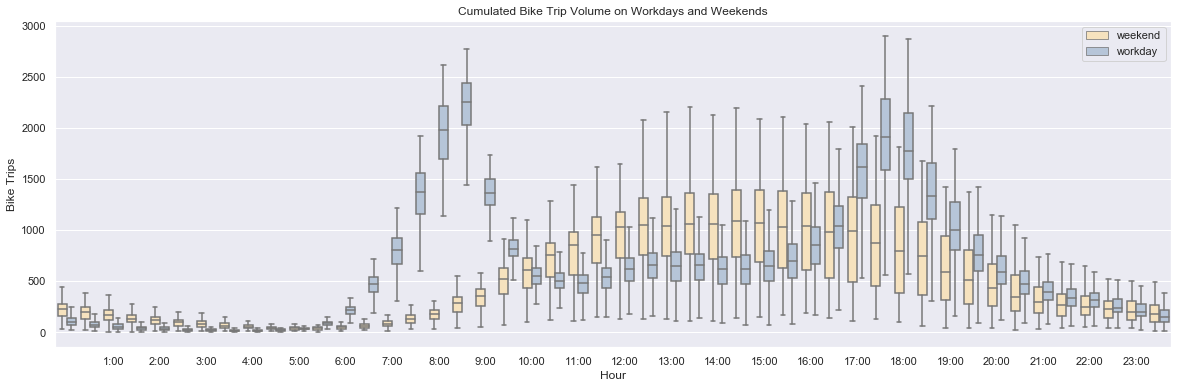

In [51]:
# plot the distribution 
sns.set(rc={'figure.figsize': (20,6)})

ax = sns.boxplot(x='hour', y='bike_trips', data=all_trips, hue='workday', showfliers=False, palette = pal_workday)
ax.set_title(f"Cumulated Bike Trip Volume on Workdays and Weekends")
hndl, lgnd = ax.get_legend_handles_labels()
ax.legend(hndl, ['weekend', 'workday'])
ax.set_xticklabels(['', '', '1:00', '', '2:00', '', '3:00', '', '4:00', '', '5:00', '', '6:00', '', '7:00', '', '8:00', '', '9:00', '', '10:00', '', '11:00', '', '12:00', \
                        '', '13:00', '', '14:00', '', '15:00', '', '16:00', '', '17:00', '', '18:00',  '', '19:00', '', '20:00', '', '21:00', '', '22:00', '', '23:00', ''])
plt.xlabel('Hour')
plt.ylabel('Bike Trips')

plt.show()

Visualising trip distribution over the day shows two different patterns:
- One peak in the afternoon for weekends,
- Two apparent commuter peaks for workdays.

## 3.2 Temperature

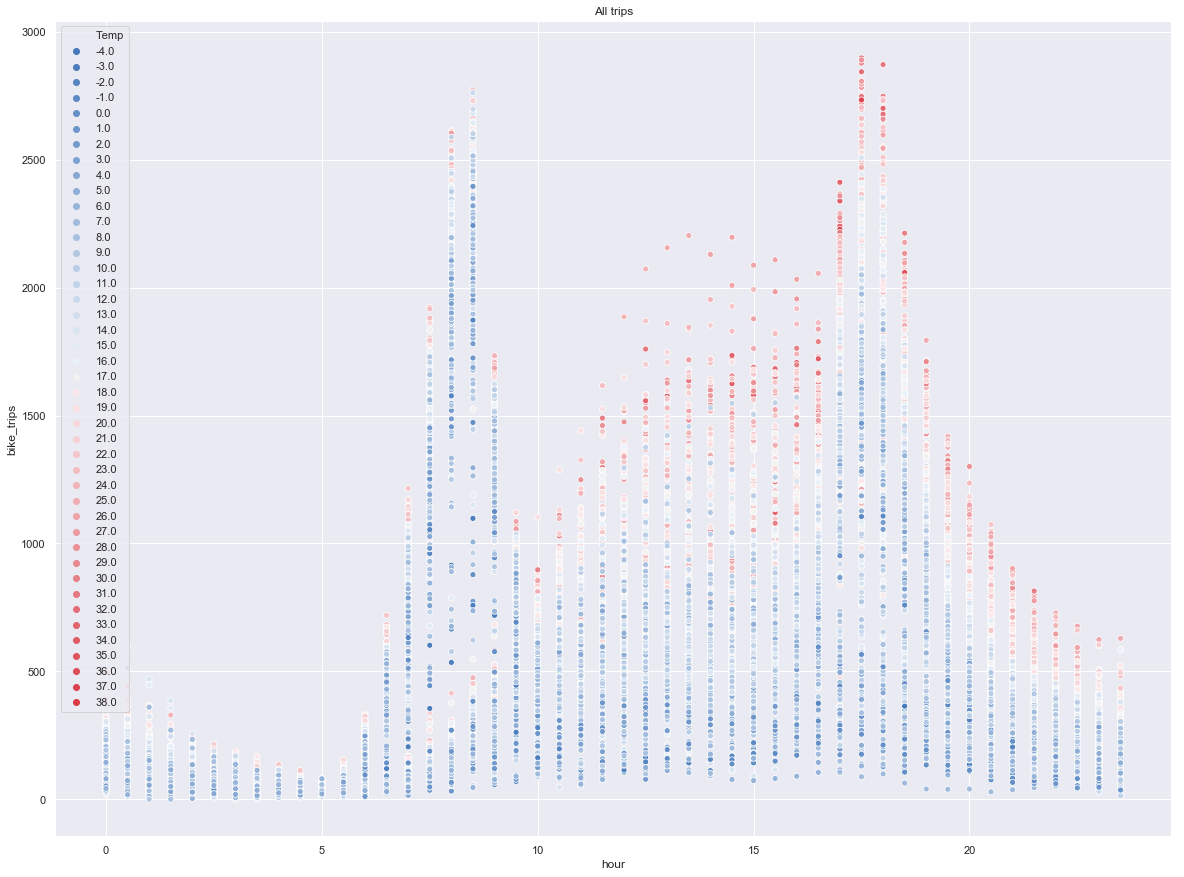

In [54]:
# general graphics settings
sns.set(rc={'figure.figsize': (20,15)})

# palette with one colour for each temperature
temp_pal = temperature_palette(all_trips.Temp)
ax = sns.scatterplot(x='hour', y='bike_trips', hue='Temp', data=all_trips, palette = temp_pal) #, legend=False)
ax.set_title(f"All trips")

plt.show()

As suggested by the literature commuting appears more resilient in regard to temperature than leisure use: morning peaks have higher volumes in cold weather (dark blue) and evening peaks higher volumes in hot weather (dark red). The centre peak has less bike trip volumes in hot weather (dark red), moderate weather (light red) produces higher volumes.

## 3.3 Rain

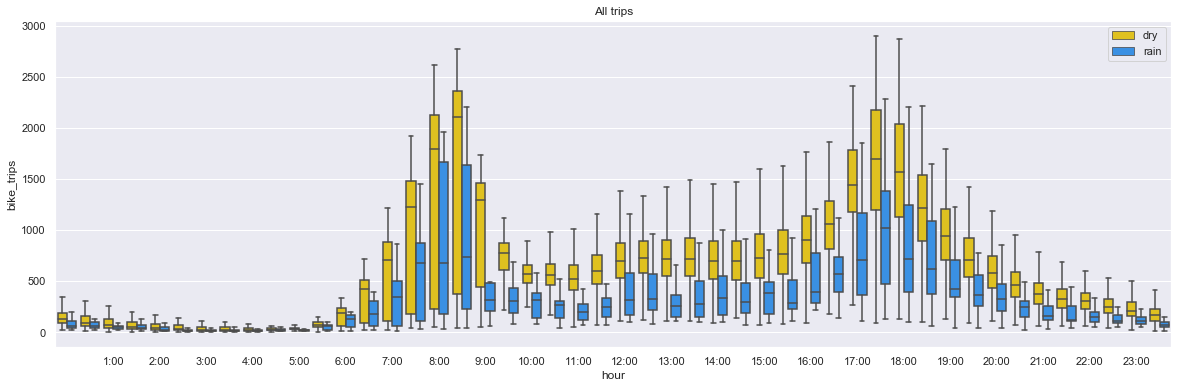

In [55]:
sns.set(rc={'figure.figsize': (20,6)})

ax = sns.boxplot(x='hour', y='bike_trips', hue='rainfall', data=all_trips, palette = pal_rain, showfliers=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['dry', 'rain'])
ax.set_xticklabels(['', '', '1:00', '', '2:00', '', '3:00', '', '4:00', '', '5:00', '', '6:00', '', '7:00', '', '8:00', '', '9:00', '', '10:00', '', '11:00', '', '12:00', \
                        '', '13:00', '', '14:00', '', '15:00', '', '16:00', '', '17:00', '', '18:00',  '', '19:00', '', '20:00', '', '21:00', '', '22:00', '', '23:00', ''])
ax.set_title(f"All trips")

plt.show()

The third graph plots trip volume against time period adding rain. The morning commute appears least affected by rain, but bike trip volumes are consistently lower in rain. 

## 3.4 Clustering

I will run a k-means algorithm (k=3) against the date and time attributes to see if bike use patterns can be identified as clusters.

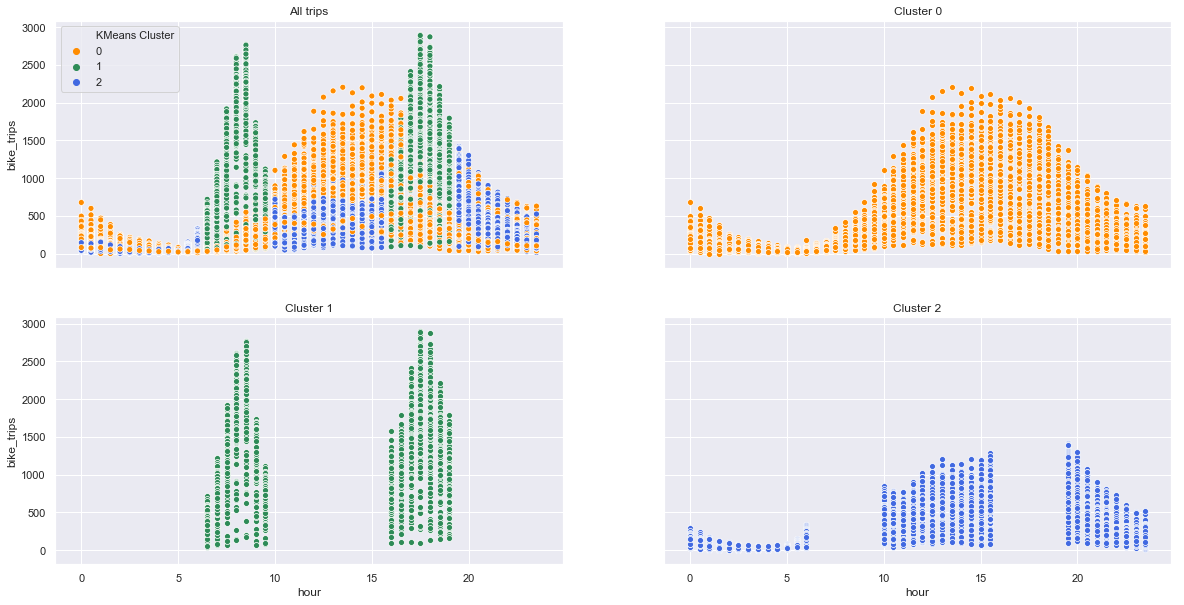

In [14]:
# Scale the features: km_scaled
km_scaled = scale(all_trips.loc[:,['workday', 'hour', 'peak_travel']])

km_scaled

km = KMeans(n_clusters = 3, random_state=42)
all_trips['KMeans Cluster'] = km.fit_predict(km_scaled)

kmcl = all_trips['KMeans Cluster'].unique()
#print(f"{kmcl}")

f, axes = plt.subplots(2, 2, figsize=(20,10), sharex=True, sharey=True)

# all bike trips
curr_ax = axes[0,0]
sns.scatterplot(x='hour', y='bike_trips', hue='KMeans Cluster', data=all_trips, ax=curr_ax, palette = ['darkorange', 'seagreen', 'royalblue']) #, legend=False)
curr_ax.set_title(f"All trips")

# cluster 1
curr_ax = axes[0,1]
sns.scatterplot(x='hour', y='bike_trips', data=all_trips[all_trips['KMeans Cluster']==0], ax=curr_ax, color='darkorange')
curr_ax.set_title(f"Cluster 0")

# cluster 2
curr_ax = axes[1,0]
sns.scatterplot(x='hour', y='bike_trips', data=all_trips[all_trips['KMeans Cluster']==1], ax=curr_ax, color='seagreen')
curr_ax.set_title(f"Cluster 1")

# cluster 3
curr_ax = axes[1,1]
sns.scatterplot(x='hour', y='bike_trips', data=all_trips[all_trips['KMeans Cluster']==2], ax=curr_ax, color='royalblue')
curr_ax.set_title(f"Cluster 2")

plt.show()

The clusters appear to reflect three usage types, weekend (and bank holiday) use, workday commute use, and workday non-commute. <br>
I will train and test each model against all four datasets. <br>

In [15]:
# split the data into clusters
trips_cl_0 = all_trips[all_trips['KMeans Cluster'] == 0]
trips_cl_1 = all_trips[all_trips['KMeans Cluster'] == 1]
trips_cl_2 = all_trips[all_trips['KMeans Cluster'] == 2]

print(f"Number of observations for all bike trips: {len(all_trips.index)}")
print(f"Number of observations for cluster 0     :  {len(trips_cl_0.index)}")
print(f"Number of observations for cluster 1     :  {len(trips_cl_1.index)}")
print(f"Number of observations for cluster 2     :  {len(trips_cl_2.index)}")
# # work day peak hour trips
# peak_trips = all_trips[all_trips['KMeans Cluster'] == 2]
# # work day off peak hour trips
# wd_off_peak = all_trips[all_trips['KMeans Cluster'] == 1]
# # weekend / bank holiday trips
# weekend_trips = all_trips[all_trips['KMeans Cluster'] == 0]

Number of observations for all bike trips: 17486
Number of observations for cluster 0     :  5420
Number of observations for cluster 1     :  3518
Number of observations for cluster 2     :  8548


## 3.5 Correlation Matrix

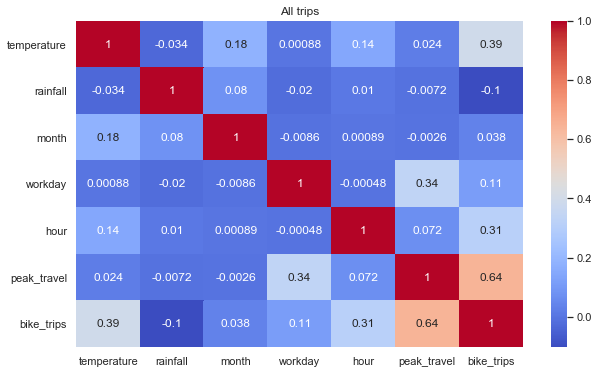

In [16]:
# all bike trips
sns.set(rc={'figure.figsize': (10,6)})
ax = sns.heatmap(all_trips.loc[:,['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel', 'bike_trips']].corr(), annot=True, cmap='coolwarm')
ax.set_title(f"All trips")
plt.show()

For all trips the attributes temperature and peak travel have the strongest correlation to bike trip volumes. <br>

In [57]:
# Pearson and Spearman correlation, note: spearman is more resistant in regards to outliers

print(f"Pearson and Spearman correlation coefficients and their p-values.\n")

battribs = ['temperature', 'rainfall', 'month', 'workday', 'hour']

for battrib in battribs:
    print(f"Correlation between 'bike trips' and '{battrib}'")
    p_corr = pearsonr(all_trips['bike_trips'], all_trips[battrib])
    s_corr = spearmanr(all_trips['bike_trips'], all_trips[battrib])
    print(f" Pearson : correlation = {p_corr[0]:.4f}, p-value = {p_corr[1]:.6f},"
          f" Spearman: correlation = {s_corr[0]:.4f}, p-value = {s_corr[1]:.6f}\n")

Pearson and Spearman correlation coefficients and their p-values.

Correlation between 'bike trips' and 'temperature'
 Pearson : correlation = 0.3947, p-value = 0.000000, Spearman: correlation = 0.4075, p-value = 0.000000

Correlation between 'bike trips' and 'rainfall'
 Pearson : correlation = -0.1037, p-value = 0.000000, Spearman: correlation = -0.1113, p-value = 0.000000

Correlation between 'bike trips' and 'month'
 Pearson : correlation = 0.0385, p-value = 0.000000, Spearman: correlation = 0.0420, p-value = 0.000000

Correlation between 'bike trips' and 'workday'
 Pearson : correlation = 0.1146, p-value = 0.000000, Spearman: correlation = 0.0769, p-value = 0.000000

Correlation between 'bike trips' and 'hour'
 Pearson : correlation = 0.3109, p-value = 0.000000, Spearman: correlation = 0.4620, p-value = 0.000000



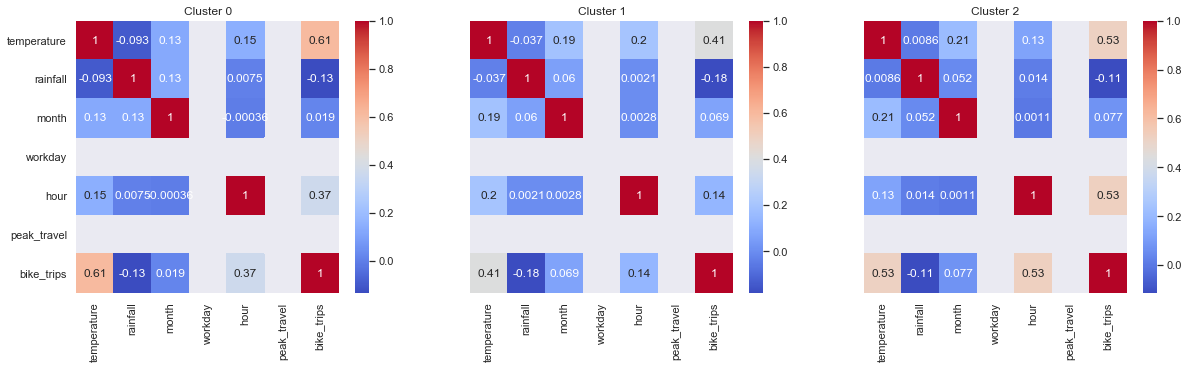

In [18]:
f, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)

# cluster 0
curr_ax = axes[0]
sns.heatmap(trips_cl_0.loc[:,['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel', 'bike_trips']].corr(), annot=True, cmap='coolwarm', ax=curr_ax)
curr_ax.set_title(f"Cluster 0")

# cluster 1
curr_ax = axes[1]
sns.heatmap(trips_cl_1.loc[:,['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel', 'bike_trips']].corr(), annot=True, cmap='coolwarm', ax=curr_ax)
curr_ax.set_title(f"Cluster 1")

# cluster 2
curr_ax = axes[2]
sns.heatmap(trips_cl_2.loc[:,['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel', 'bike_trips']].corr(), annot=True, cmap='coolwarm', ax=curr_ax)
curr_ax.set_title(f"Cluster 2")

plt.show()

Correlation matrix for Clusters 1 to 2

# 4 Modelling

This is a regression task with 17486 samples in the full data set and 3518, 5420, and 8548 respectively in the cluster data sets.<br> <br>
__Test and Train__: I will split each data set into 70% train and 30% test<br>
__Training__: I will train each model using 5-fold cross validation and grid search for hyperparameter tuning and will use the best model to test against the test data set. I will show the hyperparameters for the best model.<br>
__Evaluation__: training score, R2 score, root mean square error, and mean absolute error for less influence of outliers. <br> <br>
__Attributes__: <br>
The datasets have the attributes: 
- temperature (continuous), 
- rainfall (categorical, 0 or 1), 
- month (numeric), 
- hour (decimal), 
- workday (categorical, 0 or 1), and 
- peak travel (categorical, 0 or 1); <br>

All modelling will be done in Python using SKLearn libraries. <br> <br>
I will train each algorithm in a function that returns a dictionary with the best model, the hyperparameters for the best model, training score, a table with observed, predicted, and residual values, a table which allows me to plot observed against predicted data, and test score and RMSE. <br> <br>
For each model I will print the scores, the hyperparameters for the best model, and plot observed versus predicted values and the residual distributions

In [61]:
# Import libraries
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# test size for train:test split
n_test = .3

# define the folds for cross-fold validation
n_cv = 5

# split all four datasets into train and test as such:
# all_trips: all_attr_train, all_attr_test, all_trips_train, all_trips_test
all_attr_train, all_attr_test, all_trips_train, all_trips_test = train_test_split(all_trips.loc[:, ['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel']], \
                                                                                  all_trips.loc[:, ['bike_trips']],
                                                                                  test_size = n_test, random_state=42) 

# trips_cl_0: cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test
cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test = train_test_split(trips_cl_0.loc[:, ['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel']], \
                                                                                  trips_cl_0.loc[:, ['bike_trips']], 
                                                                                  test_size = n_test, random_state=42) 

# trips_cl_1: cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test
cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test = train_test_split(trips_cl_1.loc[:, ['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel']], \
                                                                                  trips_cl_1.loc[:, ['bike_trips']], 
                                                                                  test_size = n_test, random_state=42) 

# trips_cl_2: cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test
cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test = train_test_split(trips_cl_2.loc[:, ['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel']], \
                                                                                  trips_cl_2.loc[:, ['bike_trips']], 
                                                                                  test_size = n_test, random_state=42) 


def f_observed_predicted(observed, predicted):
    """collect data and statistics about observed and predicted data when testing the model"""
    # columns observed number of trips, predicted number of trips, residuals, and hour
    model_results = observed.copy()
    model_results.rename(columns={'bike_trips': 'observed'}, inplace=True)
    model_results['predicted'] = predicted.astype(int)
    model_results['residual_abs'] = model_results.observed - model_results.predicted
    model_results['time_stamp'] = model_results.index
    model_results['hour'] = model_results.time_stamp.dt.hour + model_results.time_stamp.dt.minute / 60

    # table to plot bike trip volume per time interval and type (observed or predicted)
    mdl_1 = model_results.loc[:,['observed', 'hour']].copy()
    mdl_1 = mdl_1.rename(columns={'observed': 'trips'})
    mdl_1['type'] = 'observed'
    mdl_1.reset_index(drop=True,inplace=True)

    mdl_2 = model_results.loc[:,['predicted', 'hour']].copy()
    mdl_2 = mdl_2.rename(columns={'predicted': 'trips'})
    mdl_2['type'] = 'predicted'
    mdl_2.reset_index(drop=True,inplace=True)
    mdl_1 = mdl_1.append(mdl_2, ignore_index=True)

    return model_results.loc[:,['hour', 'observed', 'predicted', 'residual_abs']], mdl_1


def plot_obs_pred_type(dict_all, dict_cl0, dict_cl1, dict_cl2, mdl_algo):
    """plot model test data"""
    trip_type = dict_all['trip_type']

    # plot the distribution for all trips as one graph
    sns.set(rc={'figure.figsize': (24,6)})
    sns.set_style("white")
    ax = sns.boxplot(x='hour', y='trips', data=trip_type, hue='type', showfliers=False, palette = ['royalblue','tomato'])
    ax.set_title(f"{mdl_algo} All Data")
    ax.set_xticklabels(['', '', '1:00', '', '2:00', '', '3:00', '', '4:00', '', '5:00', '', '6:00', '', '7:00', '', '8:00', '', '9:00', '', '10:00', '', '11:00', '', '12:00', \
                        '', '13:00', '', '14:00', '', '15:00', '', '16:00', '', '17:00', '', '18:00',  '', '19:00', '', '20:00', '', '21:00', '', '22:00', '', '23:00', ''])
    plt.show()

    # plot clusters as three sub-plots next to each other
    f, axes = plt.subplots(1, 3, figsize=(24,6))

    # Cluster 0
    trip_type = dict_cl0['trip_type']
    curr_ax = axes[0]
    sns.boxplot(x='hour', y='trips', data=trip_type, hue='type', showfliers=False, palette = ['royalblue','tomato'], ax=curr_ax)
    curr_ax.set_title(f"{mdl_algo} Cluster 0")
    curr_ax.set_xticklabels(['', '', '', '', '2:00', '', '', '', '4:00', '', '', '', '6:00', '', '', '', '8:00', '', '', '', '', '10:00', '', '', '', '12:00', \
                             '', '', '', '14:00', '', '', '', '16:00', '', '', '', '18:00',  '', '', '', '20:00', '', '', '', '22:00', '', '', ''])
    curr_ax.legend()

    # Cluster 1
    trip_type = dict_cl1['trip_type']
    curr_ax = axes[1]
    sns.boxplot(x='hour', y='trips', data=trip_type, hue='type', showfliers=False, palette = ['royalblue','tomato'], ax=curr_ax)
    curr_ax.set_title(f"{mdl_algo} Cluster 1")
    curr_ax.set_xticklabels(['6:30', '7:00', '', '8:00', '', '9:00', '9:30', '16:00', '','17:00', '', '18:00', '', '19:00'])
    curr_ax.legend()

    # Cluster 2
    trip_type = dict_cl2['trip_type']
    curr_ax = axes[2]
    sns.boxplot(x='hour', y='trips', data=trip_type, hue='type', showfliers=False, palette = ['royalblue','tomato'], ax=curr_ax)
    curr_ax.set_title(f"{mdl_algo} Cluster 2")
    curr_ax.set_xticklabels(['', '', '', '', '2:00', '', '', '', '4:00', '', '', '5:30', '', '10:00', '', '', '11:30',  '', \
                             '', '', '13:30', '', '', '15:00', '', '19:30', '', '', '', '21:30', '', '', '', '23:30'])
    curr_ax.legend()

    plt.show()
    
    
def plot_residuals(dict_all, dict_cl0, dict_cl1, dict_cl2, mdl_algo):
    """plot the distribution of the residuals observed - predicted"""
    f, axes = plt.subplots(2,2, figsize=(24,10), sharex=True, sharey=True)

    # all trips
    curr_ax = axes[0,0]
    obs_pred = dict_all['observed_predicted']
    sns.distplot(obs_pred['residual_abs'], bins=101, kde=False, color='tomato', ax = curr_ax)
    curr_ax.set_title(f"{mdl_algo} Residuals all data")

    # Cluster 0
    curr_ax = axes[0,1]
    obs_pred = dict_cl0['observed_predicted']
    sns.distplot(obs_pred['residual_abs'], bins=101, kde=False, color='tomato', ax = curr_ax)
    curr_ax.set_title(f"{mdl_algo} Residuals Cluster 0")

    # Cluster 1
    curr_ax = axes[1,0]
    obs_pred = dict_cl1['observed_predicted']
    sns.distplot(obs_pred['residual_abs'], bins=101, kde=False, color='tomato', ax = curr_ax)
    curr_ax.set_title(f"{mdl_algo} Residuals Cluster 1")

    # Cluster 2
    curr_ax = axes[1,1]
    obs_pred = dict_cl2['observed_predicted']
    sns.distplot(obs_pred['residual_abs'], bins=101, kde=False, color='tomato', ax = curr_ax)
    curr_ax.set_title(f"{mdl_algo} Residuals Cluster 2")

    plt.plot()    
    
# These data frames will hold evaluation scores 
eval_cols = ['Train Score', 'R2', 'RMSE', 'MAE'] 
evaluate_model = pd.DataFrame(columns = eval_cols) 
evaluate_model = evaluate_model.astype({col: float for col in eval_cols})
# evaluate_cl0 = evaluate_trips.copy()
# evaluate_cl1 = evaluate_trips.copy()
# evaluate_cl2 = evaluate_trips.copy()


def score_model(dict_model, algo, dataset):
    """compute model evaluation data"""
    lret = []
    # training score
    lret.append(dict_model['best_train_score'].round(3))
    obs_pred = dict_model['observed_predicted']
    # R2
    lret.append(dict_model['test_score'].round(3))
    # root mean square error
    lret.append(np.sqrt(mean_squared_error(obs_pred.observed, obs_pred.predicted)).round(3))
    # mean absolute error
    lret.append(mean_absolute_error(obs_pred.observed, obs_pred.predicted).round(3))
    print(f"'{algo}' for '{dataset}': training score={lret[0]}; R2={lret[1]}; RMSE={lret[2]}, MAE={lret[3]}")
    return lret

#  statsmodels.api.qqplot(a)

## 4.1 Linear Models

In [22]:
# DataFrame to hold the weights assigned to each attribute for the different models and datasets for comparison
regression_coefs = pd.DataFrame(columns = ['temperature', 'rainfall', 'month', 'workday', 'hour', 'peak_travel']) 

### 4.1.1 Linear Regression

In [23]:
def train_linear_regression(attr_train, attr_test, trips_train, trips_test, cv_val):
    """grid search and cross-validation for linear regression
    using sklearn.linear_model.LinearRegression"""
    # instantiate the model
    linear_regression = LinearRegression(copy_X=True)
    # set up hyper parameters
    hyper_parameters = {'normalize': [False, True]}
    # instantiate the GridSearchCV object
    linear_regression_gs = GridSearchCV(linear_regression, hyper_parameters, cv=cv_val)
    # fit it to the training data
    linear_regression_gs.fit(attr_train, trips_train)
    # test the best model with test data
    trips_predict = linear_regression_gs.best_estimator_.predict(attr_test)
    # aggregate observed v predicted
    obs_pred, trip_type = f_observed_predicted(trips_test, trips_predict)    
    # calculate the test score
    test_score = linear_regression_gs.best_estimator_.score(attr_test, trips_test) 
    # calculate the test rmse
    rmse = np.sqrt(mean_squared_error(trips_test, trips_predict))
    # return values in a dictionary
    rdict = {'best_model': linear_regression_gs.best_estimator_,             
             'best_params': linear_regression_gs.best_params_,
             'best_train_score': linear_regression_gs.best_score_,
             'observed_predicted': obs_pred,
             'trip_type': trip_type,
             'test_score': test_score,
             'test_rmse': rmse}
    return rdict

In [24]:
# linear regression for all bike trip data
print_timestamp(f"start linear regression, all data")
lr_all = train_linear_regression(all_attr_train, all_attr_test, all_trips_train, all_trips_test, n_cv)
# linear regression for cluster 0
print_timestamp(f"start linear regression, cluster 0")
lr_cl0 = train_linear_regression(cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test, n_cv)
# linear regression for cluster 1
print_timestamp(f"start linear regression, cluster 1")
lr_cl1 = train_linear_regression(cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test, n_cv)
# linear regression for cluster 2
print_timestamp(f"start linear regression, cluster 2")
lr_cl2 = train_linear_regression(cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test, n_cv)

# collect model evaluation in respective data frames
evaluate_model.loc['Lin Reg All'] = score_model(lr_all, 'Linear Regression', 'All Data')
evaluate_model.loc['Lin Reg CL0'] = score_model(lr_cl0, 'Linear Regression', 'Cluster 0')
evaluate_model.loc['Lin Reg CL1'] = score_model(lr_cl1, 'Linear Regression', 'Cluster 1')
evaluate_model.loc['Lin Reg CL2'] = score_model(lr_cl2, 'Linear Regression', 'Cluster 2')

# save coefficients for comparison
regression_coefs.loc['Lin Reg All'] = lr_all['best_model'].coef_[0]
regression_coefs.loc['Lin Reg CL0'] = lr_cl0['best_model'].coef_[0]
regression_coefs.loc['Lin Reg CL1'] = lr_cl1['best_model'].coef_[0]
regression_coefs.loc['Lin Reg CL2'] = lr_cl2['best_model'].coef_[0]

'Linear Regression' for 'All Data': training score=0.623; R2=0.621; RMSE=345.64, MAE=267.526
'Linear Regression' for 'Cluster 0': training score=0.459; R2=0.472; RMSE=338.912, MAE=278.944
'Linear Regression' for 'Cluster 1': training score=0.188; R2=0.201; RMSE=546.565, MAE=464.083
'Linear Regression' for 'Cluster 2': training score=0.511; R2=0.501; RMSE=207.083, MAE=173.07


Scores for the linear model for each dataset above, graphs showing observed vs. predicted and residuals below.

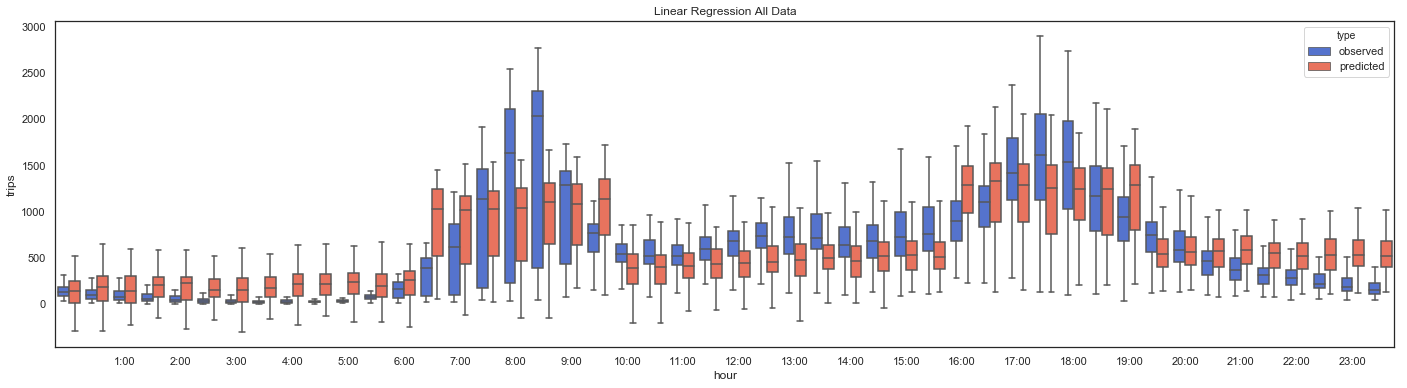

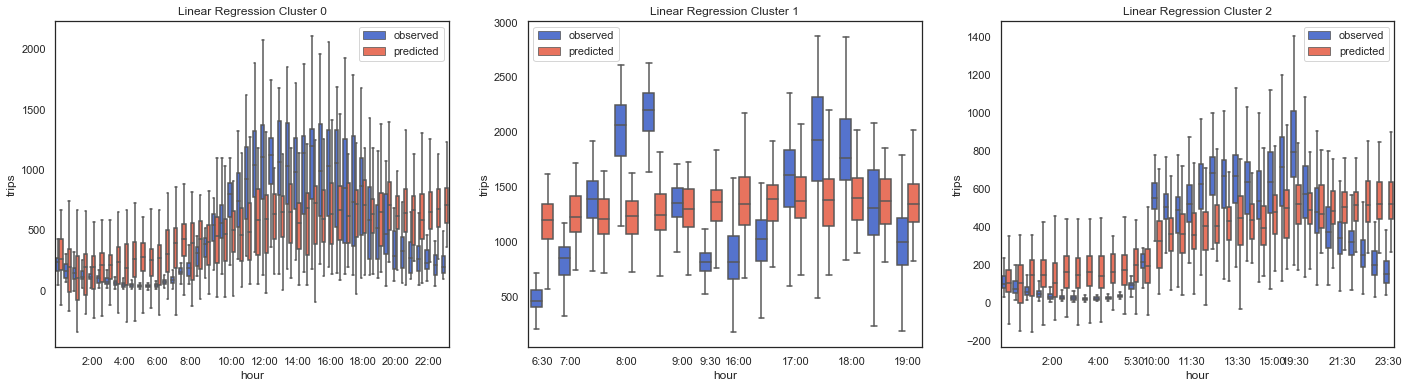

In [58]:
# plot observed and predicted data for test set for linear regression
plot_obs_pred_type(lr_all, lr_cl0, lr_cl1, lr_cl2, 'Linear Regression')

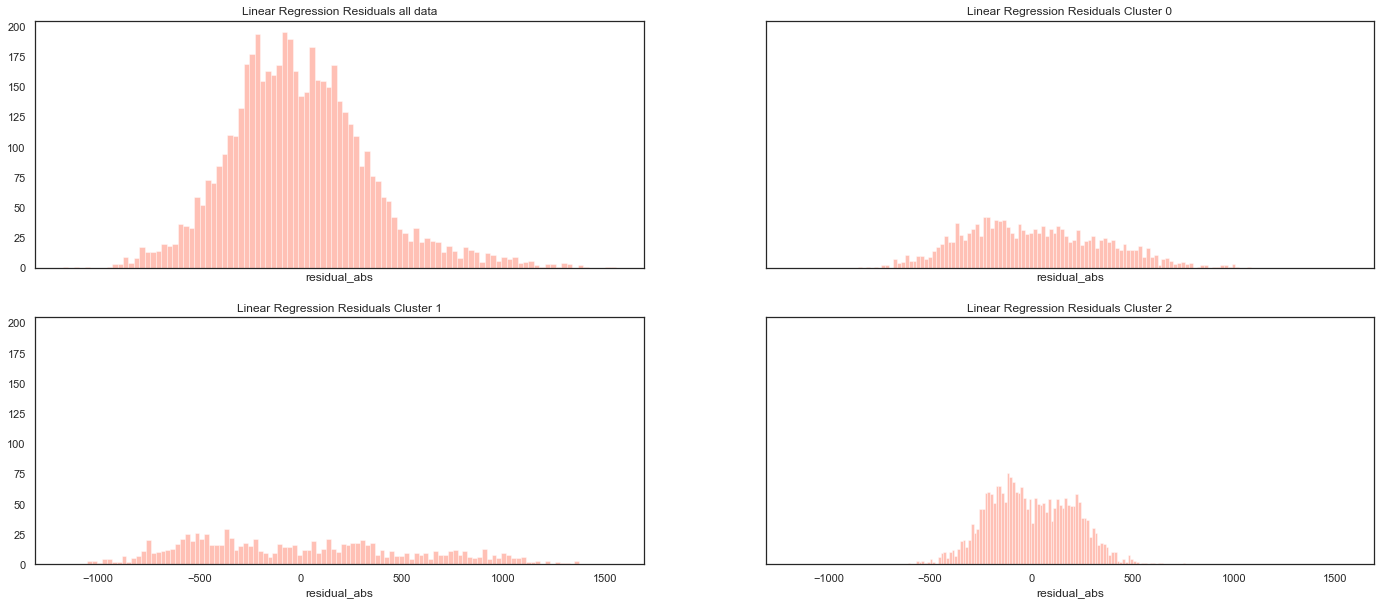

In [26]:
plot_residuals(lr_all, lr_cl0, lr_cl1, lr_cl2, 'Linear Regression')

### 4.1.2 Lasso Regressor

In [27]:
def train_lasso_regression(attr_train, attr_test, trips_train, trips_test, cv_val):
    """grid search and cross-validation for Lasso regression
    using sklearn.linear_model.Lasso"""
    # instantiate the model
    lasso = Lasso(copy_X=True)
    # set up hyper parameters
    hyper_parameters = {'alpha': np.linspace(.2, 1, 5),
                        'normalize': [True, False]}
    # instantiate the GridSearchCV object
    lasso_gs = GridSearchCV(lasso, hyper_parameters, cv=cv_val)
    # fit it to the training data
    lasso_gs.fit(attr_train, trips_train)
    # test the best model with test data
    trips_predict = lasso_gs.best_estimator_.predict(attr_test)
    # aggregate observed v predicted
    obs_pred, trip_type = f_observed_predicted(trips_test, trips_predict)
    # calculate the test score
    test_score = lasso_gs.best_estimator_.score(attr_test, trips_test) 
    # calculate the test rmse
    rmse = np.sqrt(mean_squared_error(trips_test, trips_predict))
    # return values in a dictionary
    rdict = {'best_model': lasso_gs.best_estimator_,             
             'best_params': lasso_gs.best_params_,
             'best_train_score': lasso_gs.best_score_,
             'observed_predicted': obs_pred,
             'trip_type': trip_type,
             'test_score': test_score,
             'test_rsme': rmse}
    return rdict    

In [28]:
# Lasso Regression for All Data
print_timestamp(f"start lasso, all data")
lasso_all = train_lasso_regression(all_attr_train, all_attr_test, all_trips_train, all_trips_test, n_cv)
# Lasso Regression for Cluster 0
print_timestamp(f"start lasso, cluster 0")
lasso_cl0 = train_lasso_regression(cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test, n_cv)
# Lasso Regression for Cluster 1
print_timestamp(f"start lasso, cluster 1")
lasso_cl1 = train_lasso_regression(cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test, n_cv)
# Lasso Regression for Cluster 2
print_timestamp(f"start lasso, cluster 2")
lasso_cl2 = train_lasso_regression(cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test, n_cv)

# collect model evaluation in respective tables, return best hyperparameters
evaluate_model.loc['Lasso All'] = score_model(lasso_all, 'Lasso Regression', 'All Data')
print(f"   Best parameters: {lasso_all['best_params']}")
evaluate_model.loc['Lasso CL0'] = score_model(lasso_cl0, 'Lasso Regression', 'Cluster 0')
print(f"   Best parameters: {lasso_cl0['best_params']}")
evaluate_model.loc['Lasso CL1'] = score_model(lasso_cl1, 'Lasso Regression', 'Cluster 1')
print(f"   Best parameters: {lasso_cl1['best_params']}")
evaluate_model.loc['Lasso CL2'] = score_model(lasso_cl2, 'Lasso Regression', 'Cluster 2')
print(f"   Best parameters: {lasso_cl2['best_params']}")
      
# save coefficients for comparison
regression_coefs.loc['Lasso All'] = lasso_all['best_model'].coef_
regression_coefs.loc['Lasso CL0'] = lasso_cl0['best_model'].coef_
regression_coefs.loc['Lasso CL1'] = lasso_cl1['best_model'].coef_
regression_coefs.loc['Lasso CL2'] = lasso_cl2['best_model'].coef_

'Lasso Regression' for 'All Data': training score=0.623; R2=0.621; RMSE=345.642, MAE=267.486
   Best parameters: {'alpha': 0.2, 'normalize': False}
'Lasso Regression' for 'Cluster 0': training score=0.459; R2=0.472; RMSE=338.881, MAE=278.902
   Best parameters: {'alpha': 0.2, 'normalize': False}
'Lasso Regression' for 'Cluster 1': training score=0.188; R2=0.201; RMSE=546.557, MAE=464.106
   Best parameters: {'alpha': 0.2, 'normalize': False}
'Lasso Regression' for 'Cluster 2': training score=0.511; R2=0.501; RMSE=207.108, MAE=173.091
   Best parameters: {'alpha': 0.2, 'normalize': False}


Scores and hyperparameters for the lasso model for each dataset above, graphs showing observed vs. predicted and residuals below.

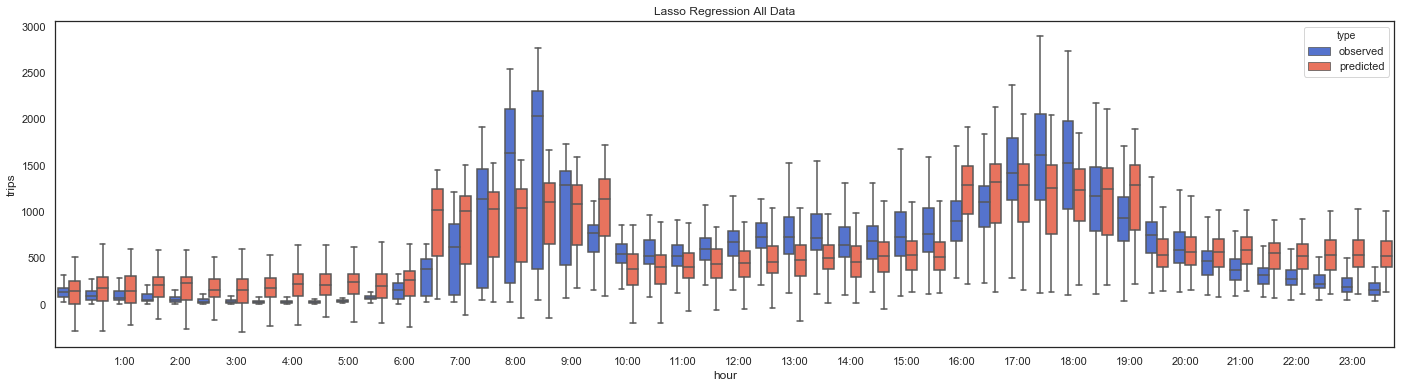

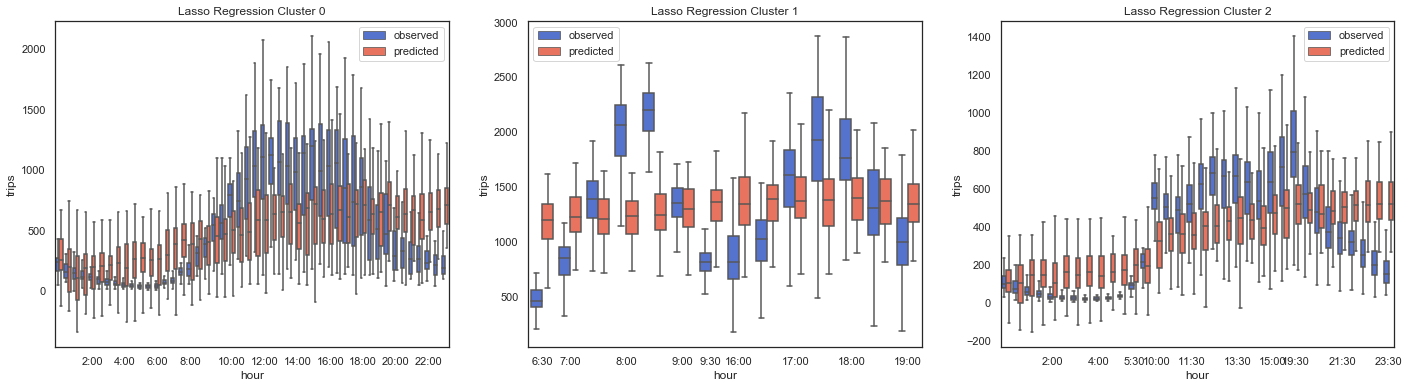

In [29]:
plot_obs_pred_type(lasso_all, lasso_cl0, lasso_cl1, lasso_cl2, 'Lasso Regression')

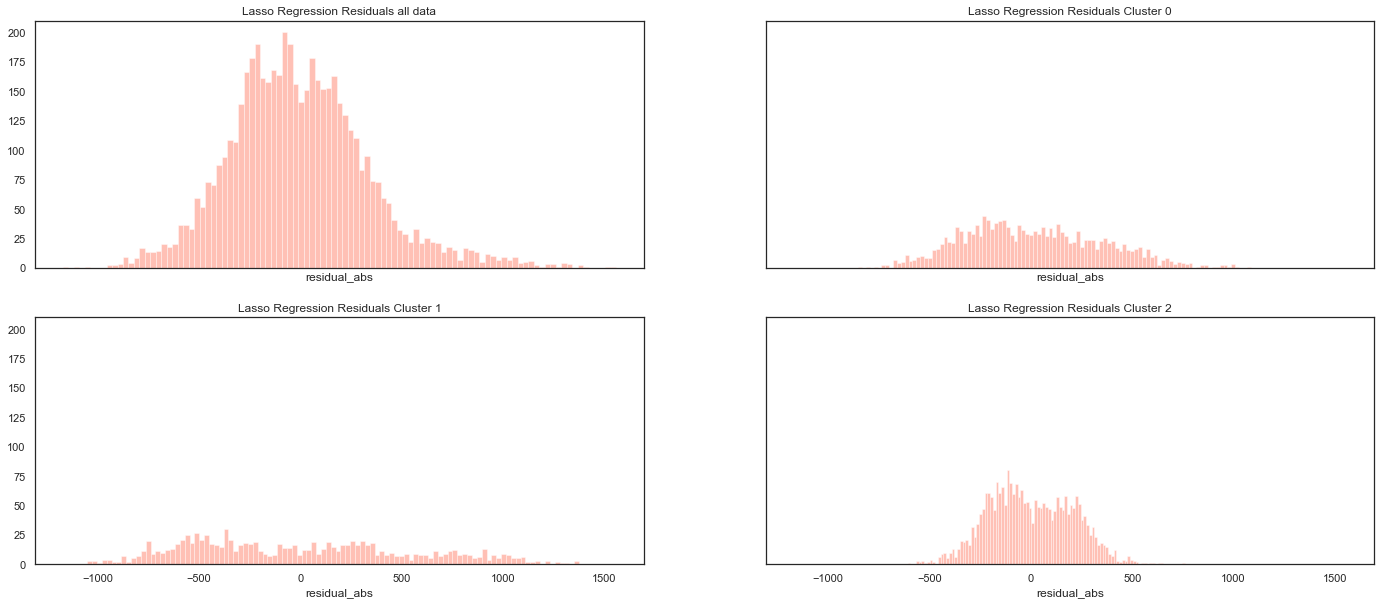

In [30]:
plot_residuals(lasso_all, lasso_cl0, lasso_cl1, lasso_cl2, 'Lasso Regression')

### 4.1.3 Elastic Net

In [31]:
def train_elastic_net(attr_train, attr_test, trips_train, trips_test, cv_val):
    """grid search and cross-validation for elastic net regression
    using sklearn.linear_model.ElasticNet"""
    # instantiate the model  
    elastic_net = ElasticNet(copy_X=True)
    # set up hyper parameters
    hyper_parameters = {'alpha': np.linspace(.2, 1, 5),                        
                        'l1_ratio': np.linspace(.2, 1, 5),
                        'normalize': [True, False]}
    # instantiate the GridSearchCV object 
    elastic_net_gs = GridSearchCV(elastic_net, hyper_parameters, cv=cv_val)
    # fit it to the training data 
    elastic_net_gs.fit(attr_train, trips_train)
    # test the best model with test data
    trips_predict = elastic_net_gs.best_estimator_.predict(attr_test)
    # aggregate observed v predicted
    obs_pred, trip_type = f_observed_predicted(trips_test, trips_predict)    
    # calculate the test score
    test_score = elastic_net_gs.best_estimator_.score(attr_test, trips_test) 
    # calculate the test rmse
    rmse = np.sqrt(mean_squared_error(trips_test, trips_predict))
    # return values in a dictionary
    rdict = {'best_model': elastic_net_gs.best_estimator_,             
             'best_params': elastic_net_gs.best_params_,
             'best_train_score': elastic_net_gs.best_score_,
             'observed_predicted': obs_pred,
             'trip_type': trip_type,
             'test_score': test_score,
             'test_rmse': rmse}
    return rdict

In [32]:
# Elastic Net regression for All Data
print_timestamp(f"start elastic net, all data")
en_all = train_elastic_net(all_attr_train, all_attr_test, all_trips_train, all_trips_test, n_cv)
# # Elastic Net regression for Cluster 0
print_timestamp(f"start elastic net, Cluster 0")
en_cl0 = train_elastic_net(cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test, n_cv)
# # Elastic Net regression for Cluster 1
print_timestamp(f"start elastic net, Cluster 1")
en_cl1 = train_elastic_net(cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test, n_cv)
# Elastic Net regression for Cluster 2
print_timestamp(f"start elastic net, Cluster 2")
en_cl2 = train_elastic_net(cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test, n_cv)

# collect model evaluation in respective tables, print best hyperparameters
evaluate_model.loc['El Net All'] = score_model(en_all, 'Elastic Net', 'All Data')
print(f"   Best parameters: {en_all['best_params']}")
evaluate_model.loc['El Net CL0'] = score_model(en_cl0, 'Elastic Net', 'Cluster 0')
print(f"   Best parameters: {en_cl0['best_params']}")
evaluate_model.loc['El Net CL1'] = score_model(en_cl1, 'Elastic Net', 'Cluster 1')
print(f"   Best parameters: {en_cl1['best_params']}")
evaluate_model.loc['El Net CL2'] = score_model(en_cl2, 'Elastic Net', 'Cluster 2')
print(f"   Best parameters: {en_cl2['best_params']}")
      
# save coefficients for comparison
regression_coefs.loc['El Net All'] = en_all['best_model'].coef_
regression_coefs.loc['El Net CL0'] = en_cl0['best_model'].coef_
regression_coefs.loc['El Net CL1'] = en_cl1['best_model'].coef_
regression_coefs.loc['El Net CL2'] = en_cl2['best_model'].coef_

'Elastic Net' for 'All Data': training score=0.623; R2=0.621; RMSE=345.642, MAE=267.486
   Best parameters: {'alpha': 0.2, 'l1_ratio': 1.0, 'normalize': False}
'Elastic Net' for 'Cluster 0': training score=0.459; R2=0.472; RMSE=338.881, MAE=278.902
   Best parameters: {'alpha': 0.2, 'l1_ratio': 1.0, 'normalize': False}
'Elastic Net' for 'Cluster 1': training score=0.188; R2=0.201; RMSE=546.557, MAE=464.106
   Best parameters: {'alpha': 0.2, 'l1_ratio': 1.0, 'normalize': False}
'Elastic Net' for 'Cluster 2': training score=0.511; R2=0.501; RMSE=207.108, MAE=173.091
   Best parameters: {'alpha': 0.2, 'l1_ratio': 1.0, 'normalize': False}


Scores and hyperparameters for the elastic net model for each dataset above, graphs showing observed vs. predicted and residuals below.

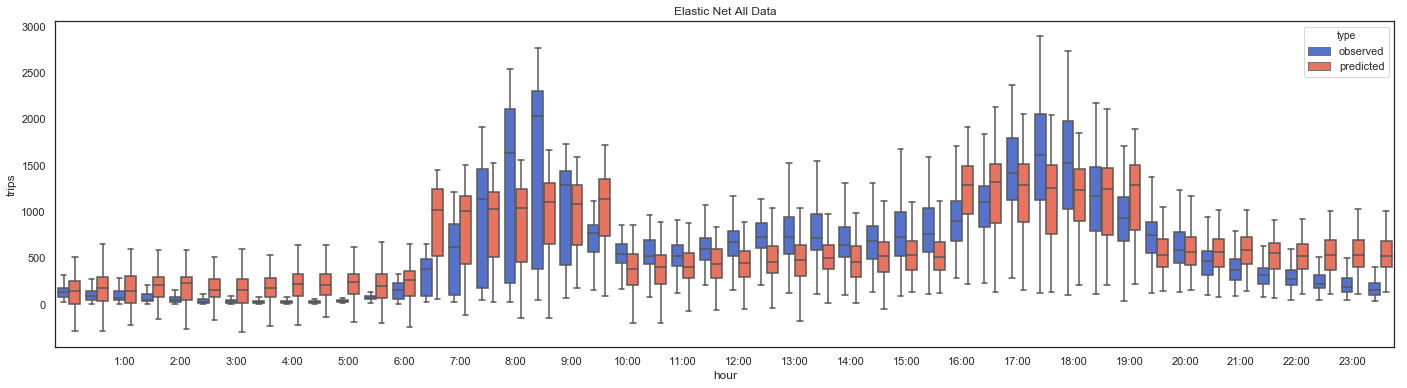

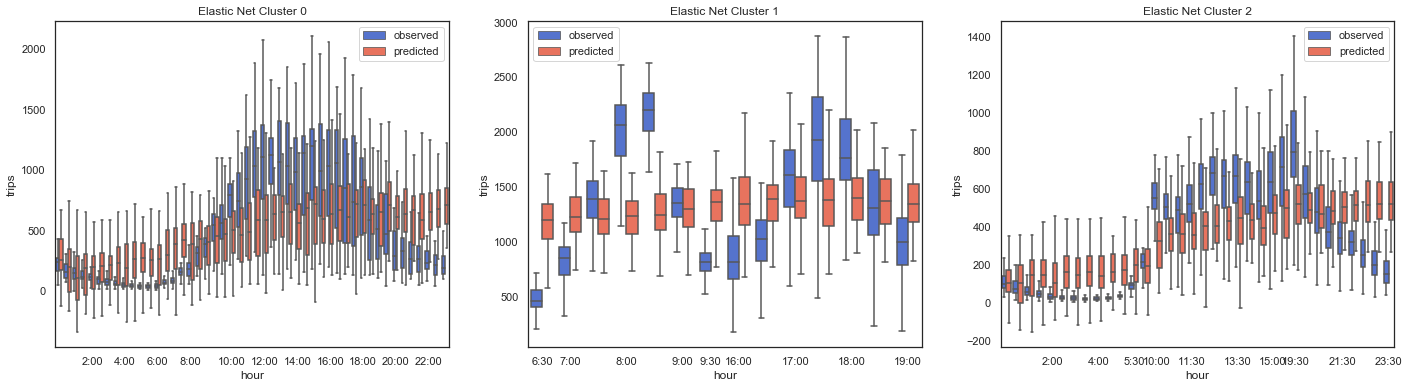

In [33]:
plot_obs_pred_type(en_all, en_cl0, en_cl1, en_cl2, 'Elastic Net')

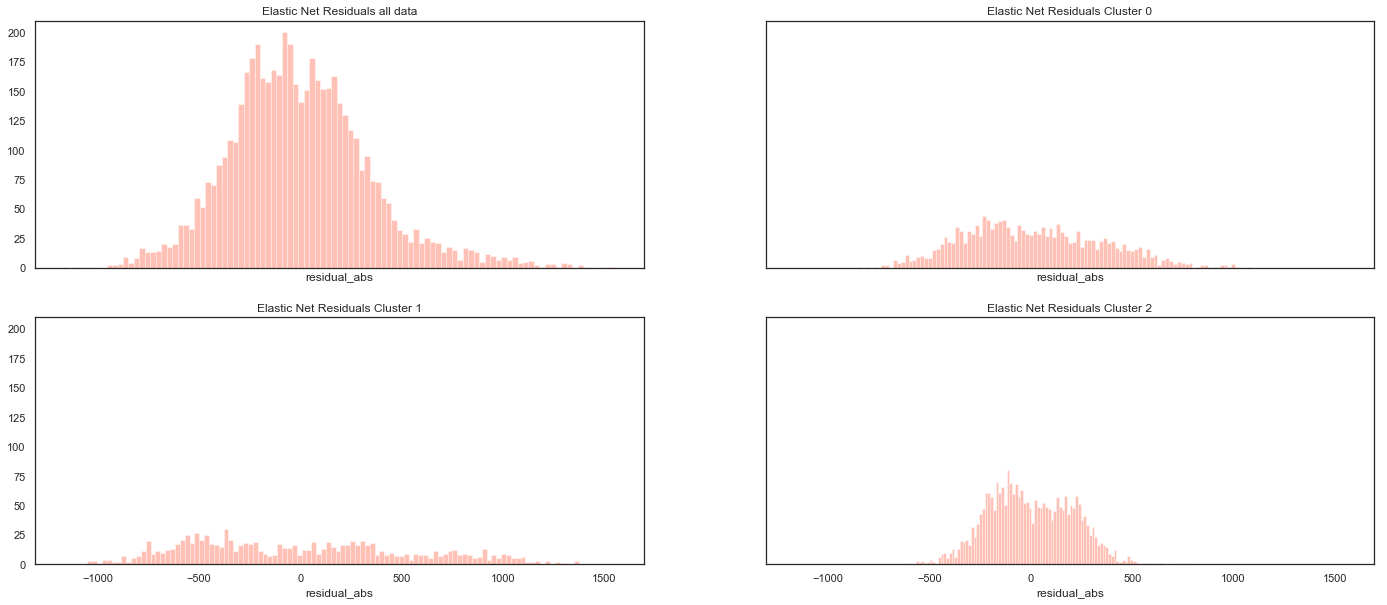

In [34]:
plot_residuals(en_all, en_cl0, en_cl1, en_cl2, 'Elastic Net')

## 4.2 Support Vector Regression

The hyperparameters for SVR are kernels radial basis function (RBF) or linear. If the grid search returns a best model with linear kernel I will add the weights to linear weights.

In [35]:
def train_svr(attr_train, attr_test, trips_train, trips_test, cv_val):
    """grid search and cross-validation for linear regression
    using sklearn.svm.SVM"""
    # instantiate the model 
    svr = SVR()
    
    # set up hyper parameters
    #hyper_parameters = {'kernel': ['linear', 'rbf']}
    hyper_parameters = {'kernel': ['rbf', 'linear']}

    # instantiate the GridSearchCV object  
    svr_gs = GridSearchCV(svr, hyper_parameters, cv=cv_val)
    # fit it to the training data
    svr_gs.fit(attr_train, trips_train)
    # test the best model with test data
    trips_predict = svr_gs.best_estimator_.predict(attr_test)
    # aggregate observed v predicted
    obs_pred, trip_type = f_observed_predicted(trips_test, trips_predict)     
    # calculate the test score
    test_score = svr_gs.best_estimator_.score(attr_test, trips_test) 
    # calculate the test rmse
    rmse = np.sqrt(mean_squared_error(trips_test, trips_predict))
    # return values in a dictionary
    rdict = {'best_model': svr_gs.best_estimator_,             
             'best_params': svr_gs.best_params_,
             'best_train_score': svr_gs.best_score_,
             'observed_predicted': obs_pred,
             'trip_type': trip_type,             
             'test_score': test_score,
             'test_rmse': rmse}
    return rdict

In [36]:
# SVR for All Data
print_timestamp(f"start support vector regressor, all data")
svr_all = train_svr(all_attr_train, all_attr_test, all_trips_train, all_trips_test, n_cv)
# SVR for Cluster 0
print_timestamp(f"start support vector regressor, cluster 0")
svr_cl0 = train_svr(cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test, n_cv)
# SVR for Cluster 1
print_timestamp(f"start support vector regressor, cluster 1")
svr_cl1 = train_svr(cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test, n_cv)
# SVR for Cluster 2
print_timestamp(f"start support vector regressor, cluster 2")
svr_cl2 = train_svr(cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test, n_cv)

# collect model evaluation in respective tables, print best hyperparameters
evaluate_model.loc['SVR All'] = score_model(svr_all, 'SVR', 'All Data')
print(f"   Best parameters: {svr_all['best_params']}")
evaluate_model.loc['SVR CL0'] = score_model(svr_cl0, 'SVR', 'Cluster 0')
print(f"   Best parameters: {svr_cl0['best_params']}")      
evaluate_model.loc['SVR CL1'] = score_model(svr_cl1, 'SVR', 'Cluster 1')
print(f"   Best parameters: {svr_cl1['best_params']}")      
evaluate_model.loc['SVR CL2'] = score_model(svr_cl2, 'SVR', 'Cluster 2')
print(f"   Best parameters: {svr_cl2['best_params']}")   

# save coefficients for comparison
if svr_all['best_params']['kernel'] == 'linear':
      regression_coefs.loc['SVR All'] = svr_all['best_model'].coef_[0]
if svr_cl0['best_params']['kernel'] == 'linear':
      regression_coefs.loc['SVR CL0'] = svr_cl0['best_model'].coef_[0]
if svr_cl1['best_params']['kernel'] == 'linear':
      regression_coefs.loc['SVR CL1'] = svr_cl1['best_model'].coef_[0]      
if svr_cl2['best_params']['kernel'] == 'linear':
      regression_coefs.loc['SVR CL2'] = svr_cl2['best_model'].coef_[0]

'SVR' for 'All Data': training score=0.539; R2=0.555; RMSE=374.726, MAE=269.15
   Best parameters: {'kernel': 'linear'}
'SVR' for 'Cluster 0': training score=0.428; R2=0.442; RMSE=348.695, MAE=276.335
   Best parameters: {'kernel': 'linear'}
'SVR' for 'Cluster 1': training score=0.134; R2=0.16; RMSE=560.291, MAE=466.993
   Best parameters: {'kernel': 'linear'}
'SVR' for 'Cluster 2': training score=0.495; R2=0.476; RMSE=212.318, MAE=174.21
   Best parameters: {'kernel': 'linear'}


Scores and hyperparameters for the support vector regressor for each dataset above, graphs showing observed vs. predicted and residuals below.

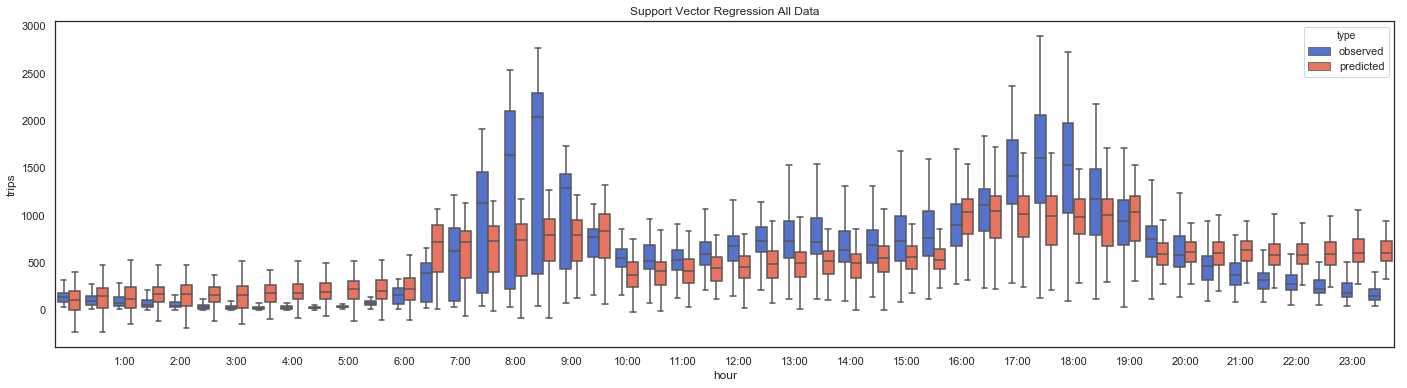

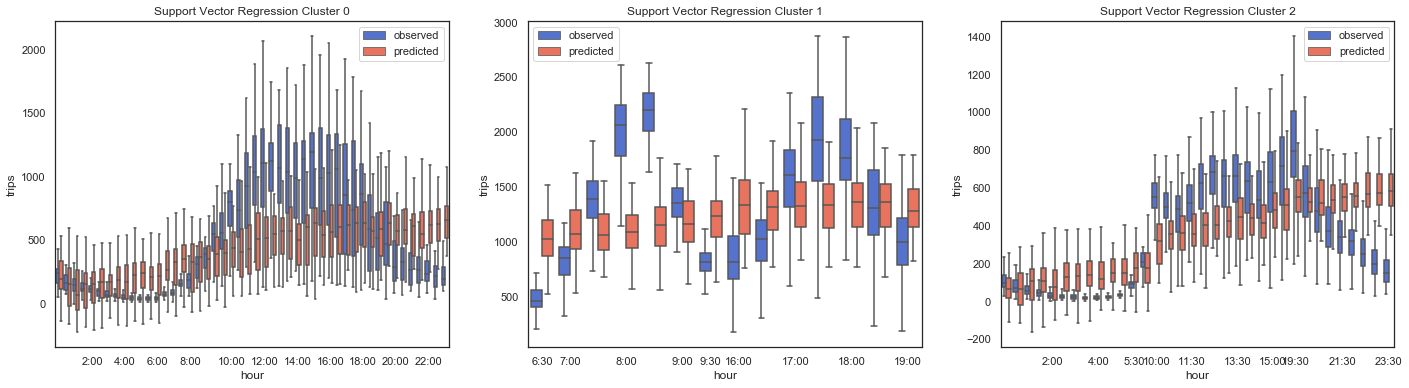

In [38]:
plot_obs_pred_type(svr_all, svr_cl0, svr_cl1, svr_cl2, 'Support Vector Regression')

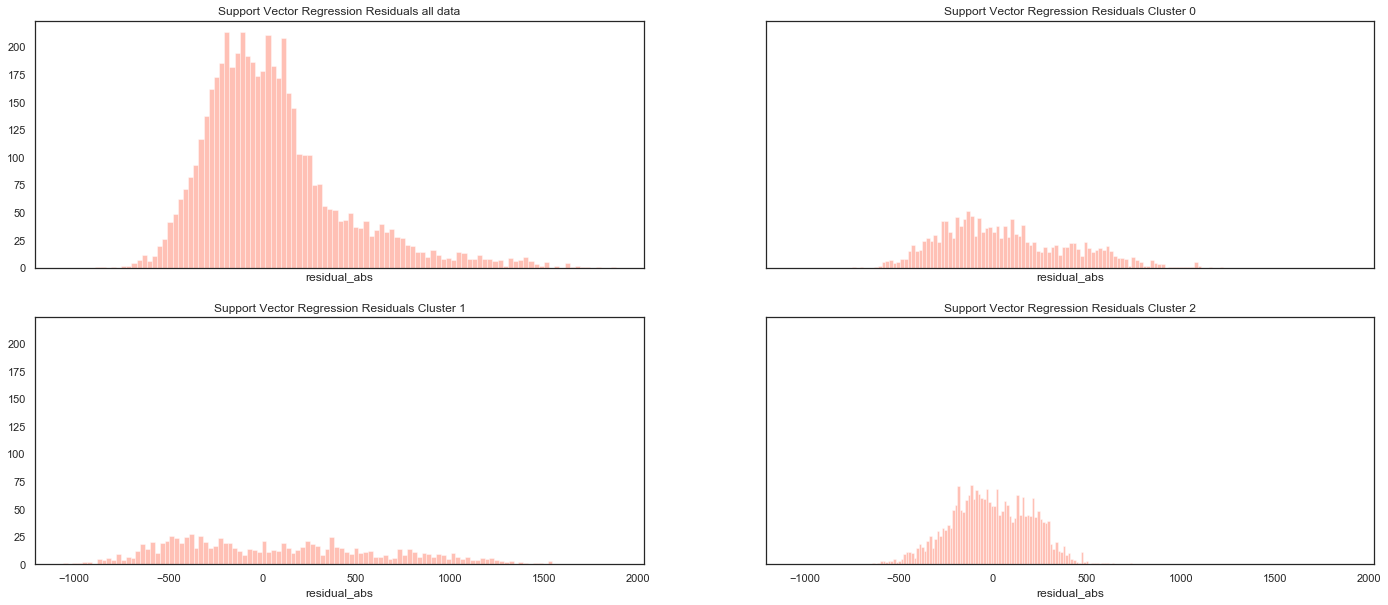

In [39]:
plot_residuals(svr_all, svr_cl0, svr_cl1, svr_cl2, 'Support Vector Regression')

## 4.3 Random Forest

In [40]:
def train_random_forest(attr_train, attr_test, trips_train, trips_test, cv_val):
    """grid search and cross-validation for linear regression
    using sklearn RandomForestRegressor"""
    # instantiate the model  
    rfr = RandomForestRegressor()
    # set up hyper parameters
    max_features = list(range(1,len(attr_train.columns)+1))
    hyper_parameters = {'n_estimators': [2, 5, 10, 20, 50, 100, 200],
                        'max_features': max_features}
    # instantiate the GridSearchCV object 
    rfr_gs = GridSearchCV(rfr, hyper_parameters, cv=cv_val)
    # fit it to the training data   
    rfr_gs.fit(attr_train, trips_train)
    # test the best model with test data
    trips_predict = rfr_gs.best_estimator_.predict(attr_test)
    # aggregate observed v predicted
    obs_pred, trip_type = f_observed_predicted(trips_test, trips_predict)     
    # calculate the test score
    test_score = rfr_gs.best_estimator_.score(attr_test, trips_test) 
    # calculate the test rmse
    rmse = np.sqrt(mean_squared_error(trips_test, trips_predict))
    # return values in a dictionary
    rdict = {'best_model': rfr_gs.best_estimator_, # feature_importances_          
             'best_params': rfr_gs.best_params_,
             'best_train_score': rfr_gs.best_score_,
             'observed_predicted': obs_pred,
             'trip_type': trip_type,             
             'test_score': test_score,
             'test_rmse': rmse}
    return rdict

In [43]:
# Random Forest for All Data
print_timestamp(f"start random forest regressor, all data")
rfr_all = train_random_forest(all_attr_train, all_attr_test, all_trips_train, all_trips_test, n_cv)
# Random Forest for Cluster 0
print_timestamp(f"start random forest regressor, Cluster 0")
rfr_cl0 = train_random_forest(cl0_attr_train, cl0_attr_test, cl0_trips_train, cl0_trips_test, n_cv)
# Random Forest for Cluster 1
print_timestamp(f"start random forest regressor, Cluster 1")
rfr_cl1 = train_random_forest(cl1_attr_train, cl1_attr_test, cl1_trips_train, cl1_trips_test, n_cv)
# Random Forest for Cluster 2
print_timestamp(f"start random forest regressor, Cluster 2")
rfr_cl2 = train_random_forest(cl2_attr_train, cl2_attr_test, cl2_trips_train, cl2_trips_test, n_cv)

# save model evaluation and print best hyperparameters
evaluate_model.loc['Rnd For All'] = score_model(rfr_all, 'Random Forest', 'All Data')
print(f"   Best parameters: {rfr_all['best_params']}")
evaluate_model.loc['Rnd For CL0'] = score_model(rfr_cl0, 'Random Forest', 'Cluster 0')
print(f"   Best parameters: {rfr_cl0['best_params']}")      
evaluate_model.loc['Rnd For CL1'] = score_model(rfr_cl1, 'Random Forest', 'Cluster 1')
print(f"   Best parameters: {rfr_cl1['best_params']}")      
evaluate_model.loc['Rnd For CL2'] = score_model(rfr_cl2, 'Random Forest', 'Cluster 2')
print(f"   Best parameters: {rfr_cl2['best_params']}")      

'Random Forest' for 'All Data': training score=0.944; R2=0.946; RMSE=130.121, MAE=77.975
   Best parameters: {'max_features': 3, 'n_estimators': 200}
'Random Forest' for 'Cluster 0': training score=0.942; R2=0.951; RMSE=103.398, MAE=67.774
   Best parameters: {'max_features': 2, 'n_estimators': 200}
'Random Forest' for 'Cluster 1': training score=0.852; R2=0.852; RMSE=235.068, MAE=164.898
   Best parameters: {'max_features': 3, 'n_estimators': 200}
'Random Forest' for 'Cluster 2': training score=0.93; R2=0.932; RMSE=76.668, MAE=48.373
   Best parameters: {'max_features': 3, 'n_estimators': 200}


Scores and hyperparameters for the random forest regressor model for each dataset above, graphs showing observed vs. predicted and residuals below.

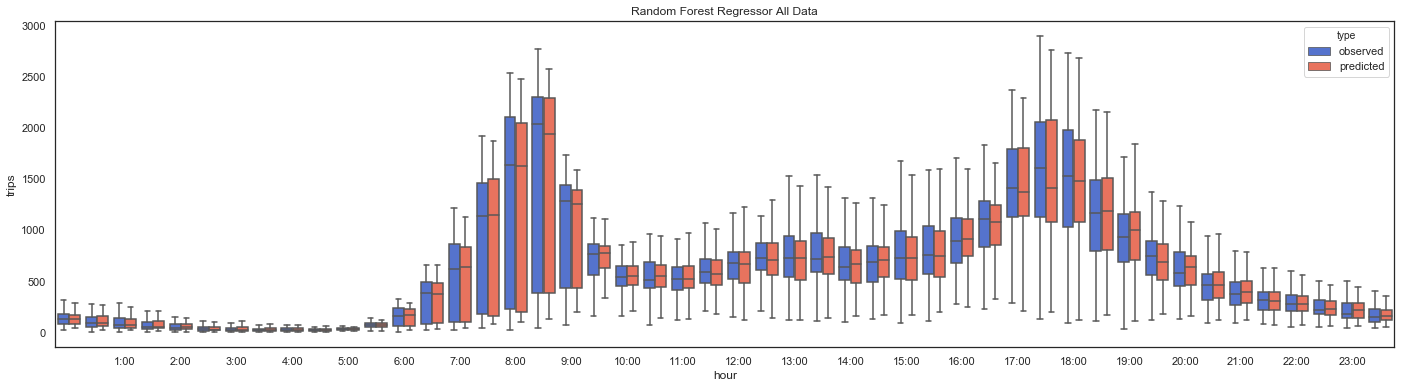

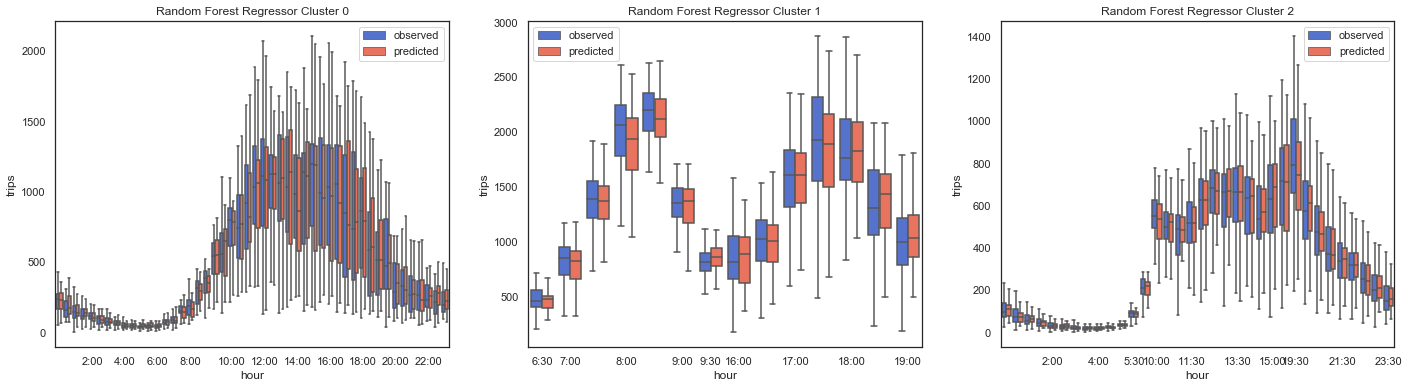

In [45]:
plot_obs_pred_type(rfr_all, rfr_cl0, rfr_cl1, rfr_cl2, 'Random Forest Regressor')

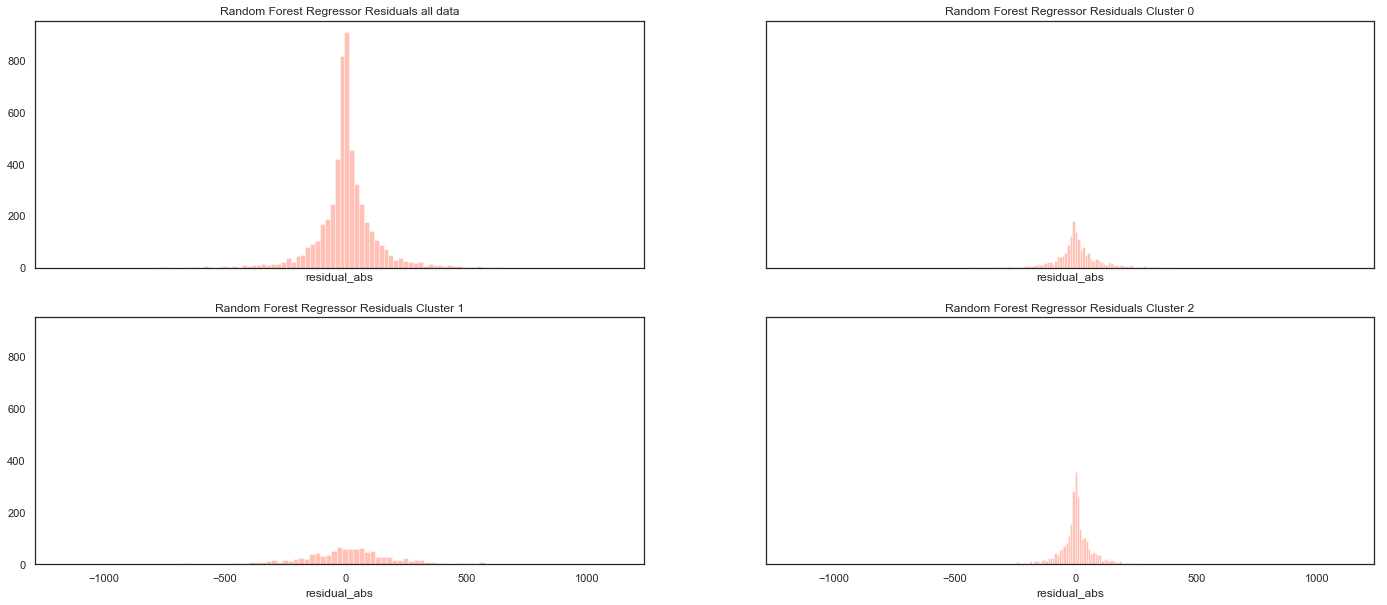

In [46]:
plot_residuals(rfr_all, rfr_cl0, rfr_cl1, rfr_cl2, 'Random Forest Regressor')

In [44]:
# Feature importance
print("All Data")
rf_features = zip(all_attr_test.columns,rfr_all['best_model'].feature_importances_)
for rf_feature in rf_features:
    print(f"   {rf_feature}")
    
print("\nCluster 0")
rf_features = zip(all_attr_test.columns,rfr_cl0['best_model'].feature_importances_)
for rf_feature in rf_features:
    print(f"   {rf_feature}")
    
print("\nCluster 1")
rf_features = zip(all_attr_test.columns,rfr_cl1['best_model'].feature_importances_)
for rf_feature in rf_features:
    print(f"   {rf_feature}")
    
print("\nCluster 2")
rf_features = zip(all_attr_test.columns,rfr_cl2['best_model'].feature_importances_)
for rf_feature in rf_features:
    print(f"   {rf_feature}")    

All Data
   ('temperature', 0.15704282906630715)
   ('rainfall', 0.013592843058152029)
   ('month', 0.03973067686772014)
   ('workday', 0.023241715628401837)
   ('hour', 0.4070513763761961)
   ('peak_travel', 0.35934055900322287)

Cluster 0
   ('temperature', 0.33755717006328095)
   ('rainfall', 0.013256323171297766)
   ('month', 0.08956839576762268)
   ('workday', 0.0)
   ('hour', 0.559618110997798)
   ('peak_travel', 0.0)

Cluster 1
   ('temperature', 0.24473930222059292)
   ('rainfall', 0.03211752536654873)
   ('month', 0.09069536767445843)
   ('workday', 0.0)
   ('hour', 0.6324478047384001)
   ('peak_travel', 0.0)

Cluster 2
   ('temperature', 0.2380652623808647)
   ('rainfall', 0.017427688766039152)
   ('month', 0.05037998339705013)
   ('workday', 0.0)
   ('hour', 0.6941270654560461)
   ('peak_travel', 0.0)


Feature importance for all models for the random forest regressor

# 5 Model Evaluation
Please read the report for model evaluation.

## 5.1 Model scores

In [73]:
import statsmodels.api as sm

def plot_residuals_qq(model_dict, title):
    """plot residuals distribution and QQ plot"""
    # data from the model dictionary
    obs_pred = model_dict['observed_predicted']
    
    f, axes = plt.subplots(1, 3, figsize=(24,6))
    # observed vs predicted
    trip_type = model_dict['trip_type']
    curr_ax = axes[0]
    sns.boxplot(x='hour', y='trips', data=trip_type, hue='type', showfliers=False, palette = ['royalblue','tomato'], ax=curr_ax)
    curr_ax.set_title(f"{title} Obs vs Pred")
    curr_ax.set_xticklabels([])
    curr_ax.legend()
    
    # residual distribution
    curr_ax = axes[1]
    sns.distplot(obs_pred['residual_abs'], bins=101, kde=False, color='tomato', ax = curr_ax)
    curr_ax.set_title(f"{title} Residuals all data")
    
    # QQ plot
    curr_ax = axes[2]
    sm.qqplot(obs_pred.residual_abs, fit=True, line='45', ax=curr_ax)
    
    plt.show()

In [48]:
evaluate_model

,Train Score,R2,RMSE,MAE
Lin Reg All,0.623,0.621,345.640,267.526
Lin Reg CL0,0.459,0.472,338.912,278.944
Lin Reg CL1,0.188,0.201,546.565,464.083
Lin Reg CL2,0.511,0.501,207.083,173.070
Lasso All,0.623,0.621,345.642,267.486
Lasso CL0,0.459,0.472,338.881,278.902
Lasso CL1,0.188,0.201,546.557,464.106
Lasso CL2,0.511,0.501,207.108,173.091
El Net All,0.623,0.621,345.642,267.486
El Net CL0,0.459,0.472,338.881,278.902


Scores for all models and datasets

In [37]:
regression_coefs

,temperature,rainfall,month,workday,hour,peak_travel
Lin Reg All,29.654444,-222.612809,-1.821860,-1.310782e+02,17.328741,928.066704
Lin Reg CL0,39.726634,-151.843737,-5.450973,0.000000e+00,19.246151,0.000000
Lin Reg CL1,34.333169,-469.836363,-1.457057,0.000000e+00,7.257040,0.000000
Lin Reg CL2,20.740518,-154.838046,-1.609194,0.000000e+00,18.370225,0.000000
Lasso All,29.656826,-218.767635,-1.825940,-1.295784e+02,17.329343,926.264764
Lasso CL0,39.735579,-148.298798,-5.469864,0.000000e+00,19.239468,0.000000
Lasso CL1,34.336794,-465.519974,-1.455644,0.000000e+00,7.252399,0.000000
Lasso CL2,20.736121,-150.488728,-1.603692,0.000000e+00,18.365150,0.000000
El Net All,29.656826,-218.767635,-1.825940,-1.295784e+02,17.329343,926.264764
El Net CL0,39.735579,-148.298798,-5.469864,0.000000e+00,19.239468,0.000000


Linear regression coefficients for all datasets and linear regression, lasso regression, elastic net regression, and support vector regressor for kerner 'linear'

## 5.2 Observed vs. Predicted, Residuals, and QQ Plots for selected Models and Datasets

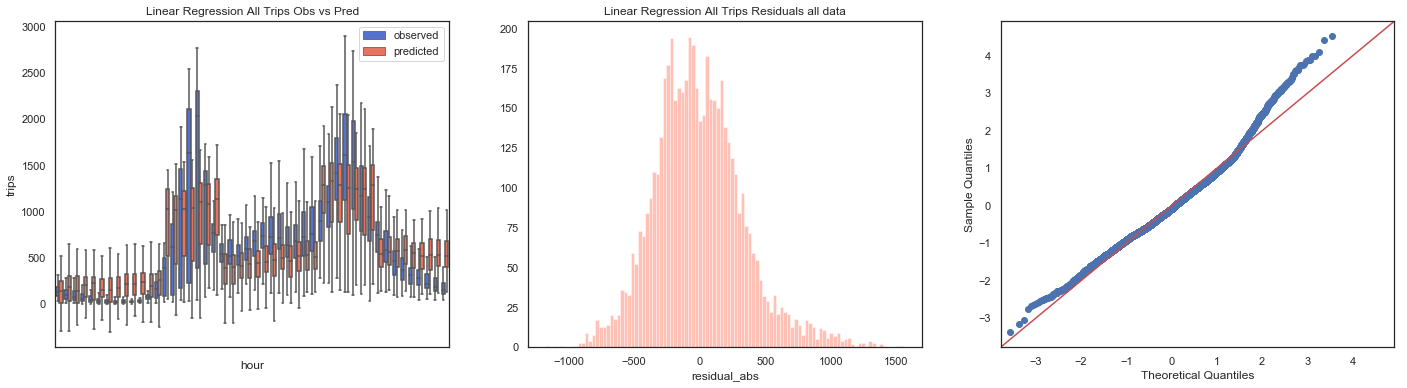

In [76]:
# plot results for linear regression and all data

plot_residuals_qq(lr_all, 'Linear Regression All Trips')

Linear regression, all trips

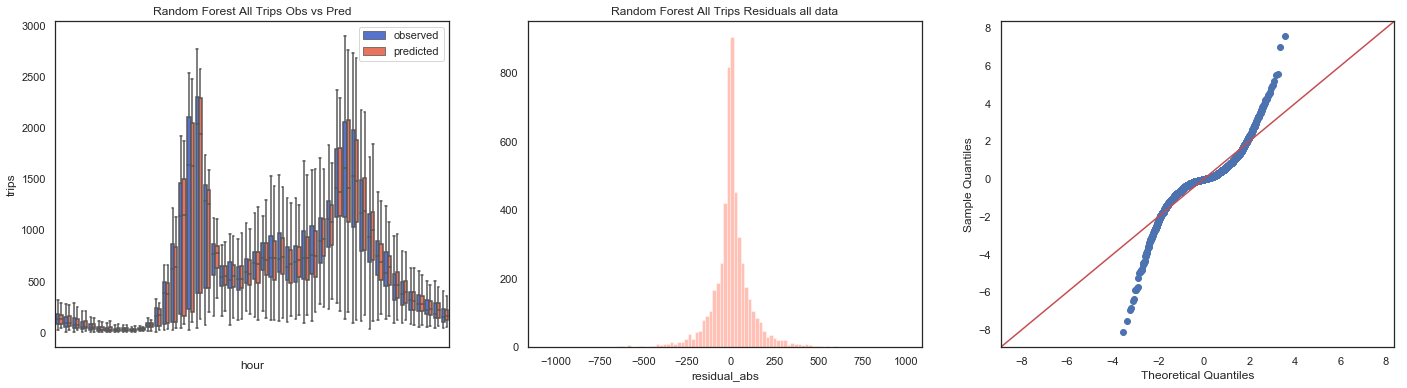

In [75]:
# plot results for random forest regressor and all data

plot_residuals_qq(rfr_all, 'Random Forest All Trips')

Random forest regressor, all trips

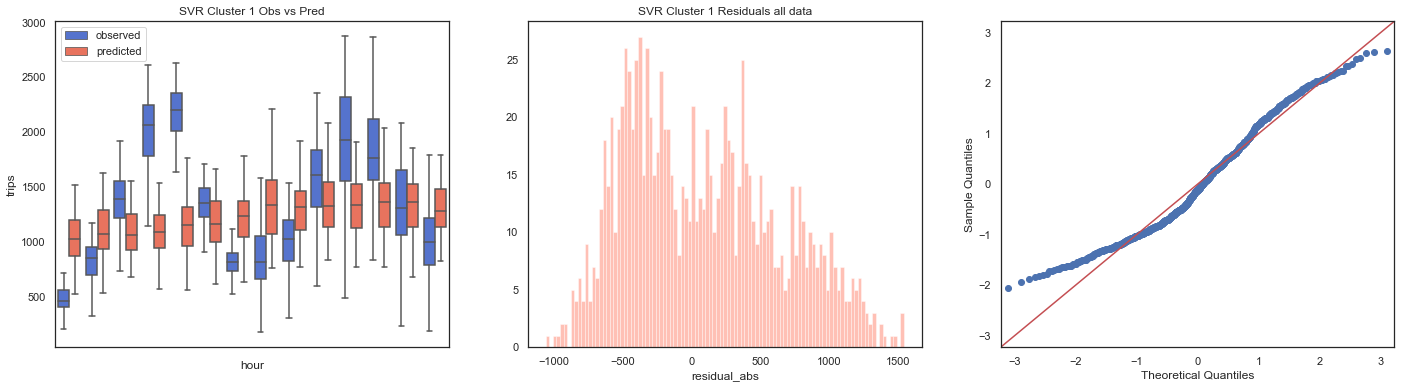

In [77]:
# plot results for SVR cluster 1

plot_residuals_qq(svr_cl1, 'SVR Cluster 1')

Support vector regressor, cluster 1